# Duplicate detection - step 3: remove true duplicates

This notebook runs the third part of the duplicate detection algorithm on a dataframe with the following columns:

- `archiveType`       (used for duplicate detection algorithm)
- `dataSetName`
- `datasetId`
- `geo_meanElev`      (used for duplicate detection algorithm)
- `geo_meanLat`       (used for duplicate detection algorithm)
- `geo_meanLon`       (used for duplicate detection algorithm)
- `geo_siteName`      (used for duplicate detection algorithm)
- `interpretation_direction`
- `interpretation_seasonality`
- `interpretation_variable`
- `interpretation_variableDetails`
- `originalDataURL`
- `originalDatabase`
- `paleoData_notes`
- `paleoData_proxy`   (used for duplicate detection algorithm)
- `paleoData_units`
- `paleoData_values`  (used for duplicate detection algorithm, test for correlation, RMSE, correlation of 1st difference, RMSE of 1st difference)
- `paleoData_variableName`
- `year`              (used for duplicate detection algorithm)
- `yearUnits`
- 
This interactive notebook (`dup_removal.ipynb`) removes the duplicates flagged in `dup_detection.ipynb`, following the decisions made in `dup_decision.ipynb`. The decisions include
- removal of redundant duplicates
- creation of composites

Based on the operator decisions as specified in `data/DATABASENAME/duplicate_detection/duplicate_decisions_DATABASENAME_AUTHORINITIALS_YY-MM-DD.csv`.

Ultimately a duplicate free dataframe is saved under 
- `data/DATABASENAME/DATABASENAME_dupfree.pkl`
- `data/DATABASENAME/DATABASENAME_dupfree_data.csv`
- `data/DATABASENAME/DATABASENAME_dupfree_year.csv`
- `data/DATABASENAME/DATABASENAME_dupfree_metadata.csv`



10/11/2025 by LL: tidied up with revised data organisation and prepared for documentation
02/12/2024 by LL: Modified the compositing process for metadata to fix bugs and make it more user friendly. Added some extra information to the bottom of the file (prior to the figures).

22/10/2024 by LL: add the composite option for duplicates (create z-scores and average over shared time period)
30/09/2024 by LL:  keep all original database values for removeed duplicates with more than one original database

Author: Lucie Luecke, created 27/9/2024



## Intialisation

### Set up working environment

Make sure the repo_root is added correctly, it should be: your_root_dir/dod2k
This should be the working directory throughout this notebook (and all other notebooks).

In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os
from pathlib import Path

# Add parent directory to path (works from any notebook in notebooks/)
# the repo_root should be the parent directory of the notebooks folder
current_dir = Path().resolve()
# Determine repo root
if current_dir.name == 'dod2k': repo_root = current_dir
elif current_dir.parent.name == 'dod2k': repo_root = current_dir.parent
else: raise Exception('Please review the repo root structure (see first cell).')

# Update cwd and path only if needed
if os.getcwd() != str(repo_root):
    os.chdir(repo_root)
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))

print(f"Repo root: {repo_root}")
if str(os.getcwd())==str(repo_root):
    print(f"Working directory matches repo root. ")

Repo root: /home/jupyter-lluecke/dod2k_v2.0/dod2k
Working directory matches repo root. 


In [2]:
import pandas as pd
import numpy as np
import datetime

from dod2k_utilities import ut_functions as utf # contains utility functions
from dod2k_utilities import ut_duplicate_search as dup # contains utility functions

### Load dataset

Define the dataset which needs to be screened for duplicates. Input files for the duplicate detection mechanism need to be compact dataframes (`pandas` dataframes with standardised columns and entry formatting). 

The function `load_compact_dataframe_from_csv` loads the dataframe from a `csv` file from `data\DB\`, with `DB` the name of the database. The database name (`db_name`) can be 
- `pages2k`
- `ch2k`
- `iso2k`
- `sisal`
- `fe23`

for the individual databases, or 

- `all_merged`

to load the merged database of all individual databases, or can be any user defined compact dataframe.

In [3]:
# load dataframe
db_name='all_merged' 
# db_name='ch2k' 
df = utf.load_compact_dataframe_from_csv(db_name)

print(df.info())
df.name = db_name


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5879 entries, 0 to 5878
Data columns (total 21 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   archiveType                    5879 non-null   object 
 1   dataSetName                    5879 non-null   object 
 2   datasetId                      5879 non-null   object 
 3   geo_meanElev                   5780 non-null   float32
 4   geo_meanLat                    5879 non-null   float32
 5   geo_meanLon                    5879 non-null   float32
 6   geo_siteName                   5879 non-null   object 
 7   interpretation_direction       5879 non-null   object 
 8   interpretation_seasonality     5879 non-null   object 
 9   interpretation_variable        5879 non-null   object 
 10  interpretation_variableDetail  5879 non-null   object 
 11  originalDataURL                5879 non-null   object 
 12  originalDatabase               5879 non-null   o

Set `datasetId` as dataframe index to reliably identify the duplicates:

In [4]:
df.set_index('datasetId', inplace = True)
df['datasetId']=df.index

### Input operator's credentials

In order to keep maximum transparency and reproduceability, put in the operator's credentials here.

These details are used to flag the intermediate output files and provided along with the final duplicate free dataset.


In [5]:
initials = 'LL'
fullname = 'Lucie Luecke'
email    = 'ljluec1@st-andrews.ac.uk'
operator_details = [initials, fullname, email]

## Apply duplicate decisions to dataframe

### Load duplicate decisions from csv

Please specify the date of the decision process below. The decision output file is then loaded from `data/DBNAME/dup_detection/dup_decisions_DBNAME_INITIALS_DATE.csv`.

In [6]:
# date = str(datetime.datetime.utcnow())[2:10]
date='25-11-11'

filename      = f'data/{df.name}/dup_detection/dup_decisions_{df.name}_{initials}_{date}'
data, header  = dup.read_csv(filename, header=True)
df_decisions  = pd.read_csv(filename+'.csv', header=5)

for hh in header:
    print(hh)
print(df_decisions.columns)
print(df.name)

 Decisions for duplicate candidate pairs. 
 Operated by Lucie Luecke (LL)
 E-Mail: ljluec1@st-andrews.ac.uk
 Created on: 2025-11-11 12:59:20.398076 (UTC)
 test test test
Index(['index 1', 'index 2', 'figure path', 'datasetId 1', 'datasetId 2',
       'originalDatabase 1', 'originalDatabase 2', 'geo_siteName 1',
       'geo_siteName 2', 'geo_meanLat 1', 'geo_meanLat 2', 'geo_meanLon 1',
       'geo_meanLon 2', 'geo_meanElevation 1', 'geo_meanElevation 2',
       'archiveType 1', 'archiveType 2', 'paleoData_proxy 1',
       'paleoData_proxy 2', 'originalDataURL 1', 'originalDataURL 2', 'year 1',
       'year 2', 'Decision 1', 'Decision 2', 'Decision type',
       'Decision comment'],
      dtype='object')
all_merged


Save a list of all candidate IDs individually (not as pairs) and collect the associated decisions. 

In [7]:
# all candidate IDs
candidate_IDs  = list(df_decisions['datasetId 1'])
candidate_IDs += list(df_decisions['datasetId 2'])
candidate_IDs  = np.unique(candidate_IDs)

# decisions
decisions = {}
for ind in df_decisions.index:
    id1, id2   = df_decisions.loc[ind, ['datasetId 1', 'datasetId 2']]
    dec1, dec2 = df_decisions.loc[ind, ['Decision 1', 'Decision 2']]
    for id, dec in zip([id1, id2], [dec1, dec2]):
        if id not in decisions: decisions[id] = []
        decisions[id]+=[dec]


Save all the duplicate details in one dictionary, which will be used in the duplicate free dataframe (final output) `df_dupfree` to provide details on the duplicate detection process.

In [8]:
dup_details = dup.provide_dup_details(df_decisions, header)

Note that any one record can appear more than once and have multiple decisions associated with it (e.g. 'REMOVE', 'KEEP' or 'COMPOSITE').

In order to remove the duplicates we need to implement the following steps:

1. Records to be REMOVED. Remove all records from the dataframe which are associated with the decision 'REMOVE' and save in `df_dupfree_rmv`
2. Records to be COMPOSITED. Create compounds of the records and save in `df_composite`
3. Now check for records which have both 'REMOVE' and 'COMPOSITE' associated. These are potentially remaining duplicates. Here, the operator is once again asked to make decisions and run a 'mini' version of the duplicate workflow. 

### 1. Records to be REMOVED

First simply remove all the records to which the decision 'REMOVE' and/or 'COMPOSITE' applies to and store in `df_dupfree_rmv`, while all 'REMOVE' type records are stored in `df_duplica_rmv` (for later inspection).

In [9]:
# load the records TO BE REMOVED
remove_IDs  = list(df_decisions['datasetId 1'][np.isin(df_decisions['Decision 1'],['REMOVE', 'COMPOSITE'])])
remove_IDs += list(df_decisions['datasetId 2'][np.isin(df_decisions['Decision 2'],['REMOVE', 'COMPOSITE'])])
remove_IDs  = np.unique(remove_IDs)

df_duplica_rmv = df.loc[remove_IDs] # df containing only records which were removed
df_dupfree_rmv = df.drop(remove_IDs) # df freed from 'REMOVE' type duplicates

print(f'Removed {len(df_duplica_rmv)} REMOVE type records.')
print(f'REMOVE type duplicate free dataset contains {len(df_dupfree_rmv)} records.')
print('Removed the following IDs:', remove_IDs)
print(df.name)

Removed 472 REMOVE type records.
REMOVE type duplicate free dataset contains 5407 records.
Removed the following IDs: ['FE23_asia_mong006' 'FE23_asia_mong007w' 'FE23_asia_mong011'
 'FE23_asia_mong012' 'FE23_asia_russ127w' 'FE23_asia_russ130w'
 'FE23_asia_russ137w' 'FE23_australia_newz003' 'FE23_australia_newz008'
 'FE23_australia_newz014' 'FE23_australia_newz018'
 'FE23_australia_newz019' 'FE23_australia_newz092' 'FE23_europe_swed019w'
 'FE23_europe_swed021w' 'FE23_northamerica_canada_cana002'
 'FE23_northamerica_canada_cana029' 'FE23_northamerica_canada_cana062'
 'FE23_northamerica_canada_cana091' 'FE23_northamerica_canada_cana094'
 'FE23_northamerica_canada_cana096' 'FE23_northamerica_canada_cana097'
 'FE23_northamerica_canada_cana100' 'FE23_northamerica_canada_cana105'
 'FE23_northamerica_canada_cana111' 'FE23_northamerica_canada_cana113'
 'FE23_northamerica_canada_cana153' 'FE23_northamerica_canada_cana155'
 'FE23_northamerica_canada_cana162' 'FE23_northamerica_canada_cana168w'
 'F

In [10]:
# add columns on decision process to df_dupfree:
df_dupfree_rmv['duplicateDetails']='N/A'
for ID in dup_details:
    if ID in df_dupfree_rmv.index: 
        if df_dupfree_rmv.at[ID, 'duplicateDetails']=='N/A': 
            df_dupfree_rmv.at[ID, 'duplicateDetails']=dup_details[ID]
        else: df_dupfree_rmv.at[ID, 'duplicateDetails']+=dup_details[ID]

In [11]:
# df_dupfree_rmv[df_dupfree_rmv[ 'duplicateDetails']!='N/A'].at['ch2k_DE14DTO03_140', 'duplicateDetails']

### 2. Records to be COMPOSITED

Now identify all the records to which the decision 'COMPOSITE' applies to, create composites and store in `df_composite`. 

pages2k_427 pages2k_433
Add the following note to duplicateDetails: archiveType: Metadata identical
Add the following note to duplicateDetails: archiveType: Metadata identicalgeo_meanElev: Metadata identical
Add the following note to duplicateDetails: archiveType: Metadata identicalgeo_meanElev: Metadata identicalgeo_meanLat: Metadata identical
Add the following note to duplicateDetails: archiveType: Metadata identicalgeo_meanElev: Metadata identicalgeo_meanLat: Metadata identicalgeo_meanLon: Metadata identical
Add the following note to duplicateDetails: archiveType: Metadata identicalgeo_meanElev: Metadata identicalgeo_meanLat: Metadata identicalgeo_meanLon: Metadata identicalgeo_siteName: Metadata identical
Add the following note to duplicateDetails: archiveType: Metadata identicalgeo_meanElev: Metadata identicalgeo_meanLat: Metadata identicalgeo_meanLon: Metadata identicalgeo_siteName: Metadata identicalpaleoData_proxy: Metadata identical
Add the following note to duplicateDetails: 

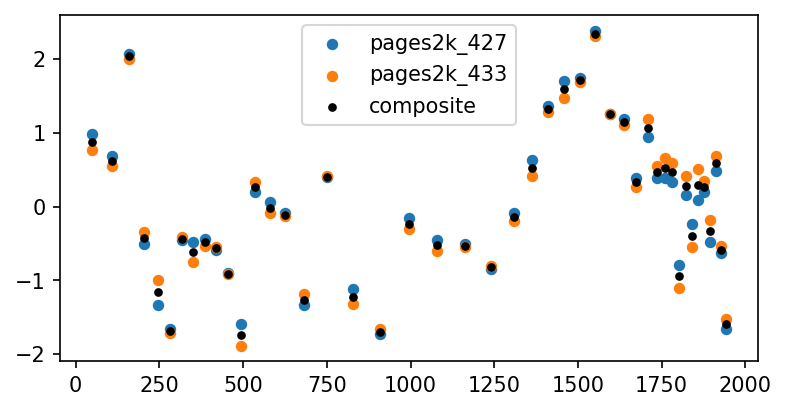

saved figure in /figs//all_merged/dup_detection//composite_pages2k_427_pages2k_433.pdf
pages2k_435 pages2k_842
Add the following note to duplicateDetails: archiveType: Metadata identical
Add the following note to duplicateDetails: archiveType: Metadata identicalgeo_meanElev: Metadata identical
Add the following note to duplicateDetails: archiveType: Metadata identicalgeo_meanElev: Metadata identicalgeo_meanLat: Metadata identical
Add the following note to duplicateDetails: archiveType: Metadata identicalgeo_meanElev: Metadata identicalgeo_meanLat: Metadata identicalgeo_meanLon: Metadata identical
Add the following note to duplicateDetails: archiveType: Metadata identicalgeo_meanElev: Metadata identicalgeo_meanLat: Metadata identicalgeo_meanLon: Metadata identicalgeo_siteName: Metadata identical
Add the following note to duplicateDetails: archiveType: Metadata identicalgeo_meanElev: Metadata identicalgeo_meanLat: Metadata identicalgeo_meanLon: Metadata identicalgeo_siteName: Metadata id

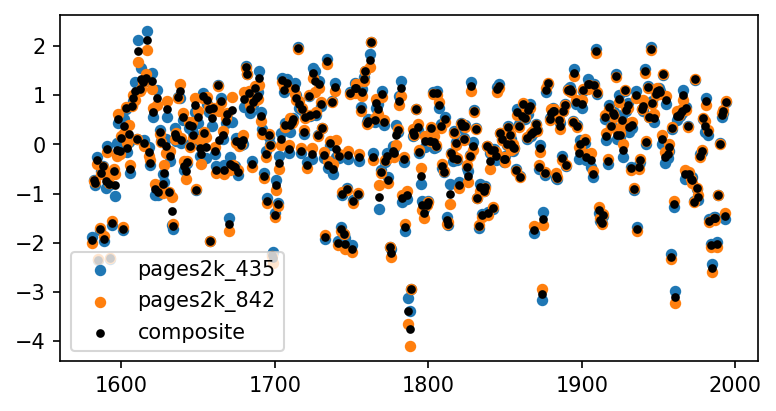

saved figure in /figs//all_merged/dup_detection//composite_pages2k_435_pages2k_842.pdf
pages2k_468 pages2k_3550
Add the following note to duplicateDetails: archiveType: Metadata identical
Add the following note to duplicateDetails: archiveType: Metadata identicalgeo_meanElev: Metadata identical
Add the following note to duplicateDetails: archiveType: Metadata identicalgeo_meanElev: Metadata identicalgeo_meanLat: Metadata identical
Add the following note to duplicateDetails: archiveType: Metadata identicalgeo_meanElev: Metadata identicalgeo_meanLat: Metadata identicalgeo_meanLon: Metadata identical
Add the following note to duplicateDetails: archiveType: Metadata identicalgeo_meanElev: Metadata identicalgeo_meanLat: Metadata identicalgeo_meanLon: Metadata identicalgeo_siteName: Metadata identical
Add the following note to duplicateDetails: archiveType: Metadata identicalgeo_meanElev: Metadata identicalgeo_meanLat: Metadata identicalgeo_meanLon: Metadata identicalgeo_siteName: Metadata i

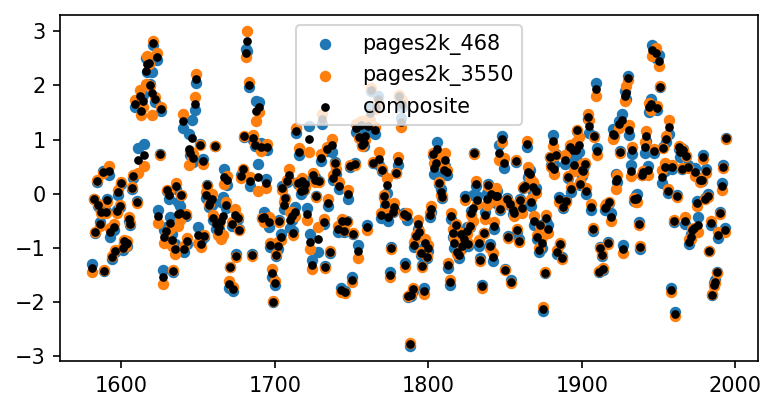

saved figure in /figs//all_merged/dup_detection//composite_pages2k_468_pages2k_3550.pdf
pages2k_2085 FE23_northamerica_canada_cana002
Add the following note to duplicateDetails: archiveType: Metadata identical
Add the following note to duplicateDetails: archiveType: Metadata identicalgeo_meanElev: Metadata identical
--------------------------------------------------------------------------------
Metadata different for >>>geo_meanLat<<< in: pages2k_2085 (58.4) and FE23_northamerica_canada_cana002 (58.366665). 
Add the following note to duplicateDetails: Metadata differs for geo_meanLat in original records: pages2k_2085 (58.4) and FE23_northamerica_canada_cana002 (58.366665). geo_meanLat: Metadata averaged to: 58.38333
--------------------------------------------------------------------------------
Metadata different for >>>geo_meanLon<<< in: pages2k_2085 (-68.4) and FE23_northamerica_canada_cana002 (-68.38333). 
Add the following note to duplicateDetails: Metadata differs for geo_meanLo

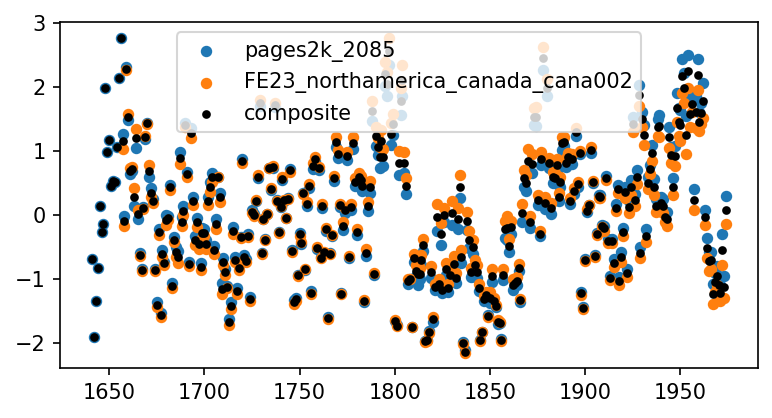

saved figure in /figs//all_merged/dup_detection//composite_pages2k_2085_FE23_northamerica_canada_cana002.pdf
pages2k_2339 pages2k_2344
Add the following note to duplicateDetails: archiveType: Metadata identical
Add the following note to duplicateDetails: archiveType: Metadata identicalgeo_meanElev: Metadata identical
Add the following note to duplicateDetails: archiveType: Metadata identicalgeo_meanElev: Metadata identicalgeo_meanLat: Metadata identical
Add the following note to duplicateDetails: archiveType: Metadata identicalgeo_meanElev: Metadata identicalgeo_meanLat: Metadata identicalgeo_meanLon: Metadata identical
Add the following note to duplicateDetails: archiveType: Metadata identicalgeo_meanElev: Metadata identicalgeo_meanLat: Metadata identicalgeo_meanLon: Metadata identicalgeo_siteName: Metadata identical
Add the following note to duplicateDetails: archiveType: Metadata identicalgeo_meanElev: Metadata identicalgeo_meanLat: Metadata identicalgeo_meanLon: Metadata identicalg

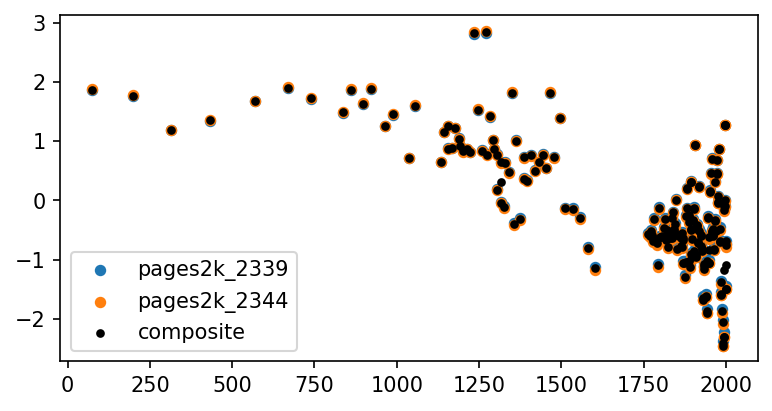

saved figure in /figs//all_merged/dup_detection//composite_pages2k_2339_pages2k_2344.pdf
pages2k_2795 pages2k_2798
Add the following note to duplicateDetails: archiveType: Metadata identical
Add the following note to duplicateDetails: archiveType: Metadata identicalgeo_meanElev: Metadata identical
Add the following note to duplicateDetails: archiveType: Metadata identicalgeo_meanElev: Metadata identicalgeo_meanLat: Metadata identical
Add the following note to duplicateDetails: archiveType: Metadata identicalgeo_meanElev: Metadata identicalgeo_meanLat: Metadata identicalgeo_meanLon: Metadata identical
Add the following note to duplicateDetails: archiveType: Metadata identicalgeo_meanElev: Metadata identicalgeo_meanLat: Metadata identicalgeo_meanLon: Metadata identicalgeo_siteName: Metadata identical
Add the following note to duplicateDetails: archiveType: Metadata identicalgeo_meanElev: Metadata identicalgeo_meanLat: Metadata identicalgeo_meanLon: Metadata identicalgeo_siteName: Metadat

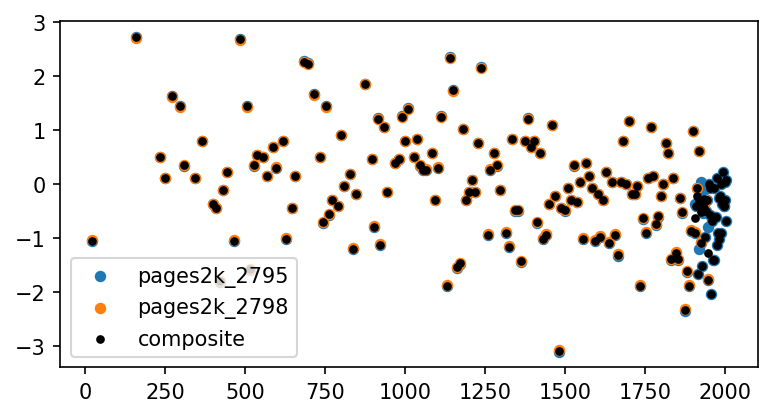

saved figure in /figs//all_merged/dup_detection//composite_pages2k_2795_pages2k_2798.pdf
pages2k_2830 FE23_northamerica_mexico_mexi020
Add the following note to duplicateDetails: archiveType: Metadata identical
Add the following note to duplicateDetails: archiveType: Metadata identicalgeo_meanElev: Metadata identical
--------------------------------------------------------------------------------
Metadata different for >>>geo_meanLat<<< in: pages2k_2830 (31.0) and FE23_northamerica_mexico_mexi020 (30.966667). 
Add the following note to duplicateDetails: Metadata differs for geo_meanLat in original records: pages2k_2830 (31.0) and FE23_northamerica_mexico_mexi020 (30.966667). geo_meanLat: Metadata averaged to: 30.983334
Add the following note to duplicateDetails: Metadata differs for geo_meanLat in original records: pages2k_2830 (31.0) and FE23_northamerica_mexico_mexi020 (30.966667). geo_meanLat: Metadata averaged to: 30.983334geo_meanLon: Metadata identical
---------------------------

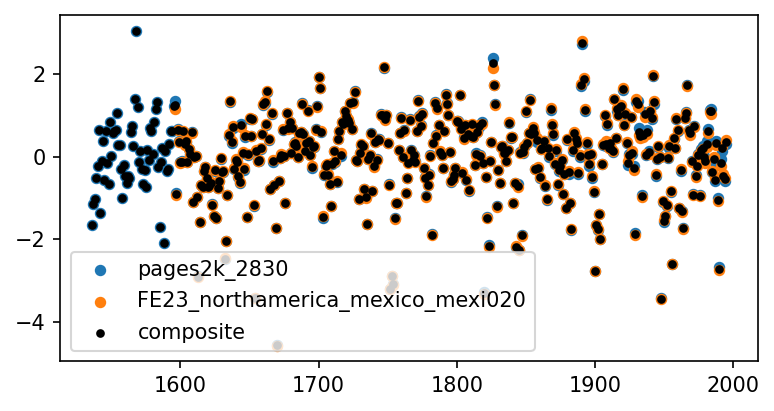

saved figure in /figs//all_merged/dup_detection//composite_pages2k_2830_FE23_northamerica_mexico_mexi020.pdf
pages2k_2843 FE23_northamerica_usa_wa083
Add the following note to duplicateDetails: archiveType: Metadata identical
Add the following note to duplicateDetails: archiveType: Metadata identicalgeo_meanElev: Metadata identical
Add the following note to duplicateDetails: archiveType: Metadata identicalgeo_meanElev: Metadata identicalgeo_meanLat: Metadata identical
--------------------------------------------------------------------------------
Metadata different for >>>geo_meanLon<<< in: pages2k_2843 (-118.3) and FE23_northamerica_usa_wa083 (-118.333336). 
Add the following note to duplicateDetails: Metadata differs for geo_meanLon in original records: pages2k_2843 (-118.3) and FE23_northamerica_usa_wa083 (-118.333336). geo_meanLon: Metadata averaged to: -118.316666
--------------------------------------------------------------------------------
Metadata different for >>>geo_siteNa

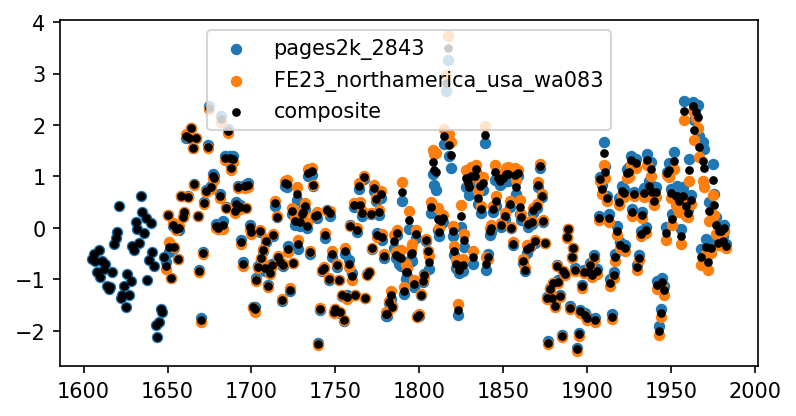

saved figure in /figs//all_merged/dup_detection//composite_pages2k_2843_FE23_northamerica_usa_wa083.pdf
pages2k_2899 pages2k_2901
Add the following note to duplicateDetails: archiveType: Metadata identical
Add the following note to duplicateDetails: archiveType: Metadata identicalgeo_meanElev: Metadata identical
Add the following note to duplicateDetails: archiveType: Metadata identicalgeo_meanElev: Metadata identicalgeo_meanLat: Metadata identical
Add the following note to duplicateDetails: archiveType: Metadata identicalgeo_meanElev: Metadata identicalgeo_meanLat: Metadata identicalgeo_meanLon: Metadata identical
Add the following note to duplicateDetails: archiveType: Metadata identicalgeo_meanElev: Metadata identicalgeo_meanLat: Metadata identicalgeo_meanLon: Metadata identicalgeo_siteName: Metadata identical
Add the following note to duplicateDetails: archiveType: Metadata identicalgeo_meanElev: Metadata identicalgeo_meanLat: Metadata identicalgeo_meanLon: Metadata identicalgeo_si

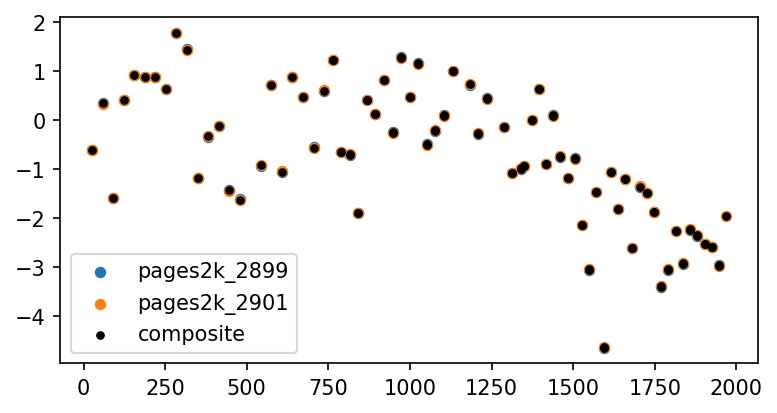

saved figure in /figs//all_merged/dup_detection//composite_pages2k_2899_pages2k_2901.pdf
pages2k_2904 pages2k_2906
Add the following note to duplicateDetails: archiveType: Metadata identical
Add the following note to duplicateDetails: archiveType: Metadata identicalgeo_meanElev: Metadata identical
Add the following note to duplicateDetails: archiveType: Metadata identicalgeo_meanElev: Metadata identicalgeo_meanLat: Metadata identical
Add the following note to duplicateDetails: archiveType: Metadata identicalgeo_meanElev: Metadata identicalgeo_meanLat: Metadata identicalgeo_meanLon: Metadata identical
Add the following note to duplicateDetails: archiveType: Metadata identicalgeo_meanElev: Metadata identicalgeo_meanLat: Metadata identicalgeo_meanLon: Metadata identicalgeo_siteName: Metadata identical
Add the following note to duplicateDetails: archiveType: Metadata identicalgeo_meanElev: Metadata identicalgeo_meanLat: Metadata identicalgeo_meanLon: Metadata identicalgeo_siteName: Metadat

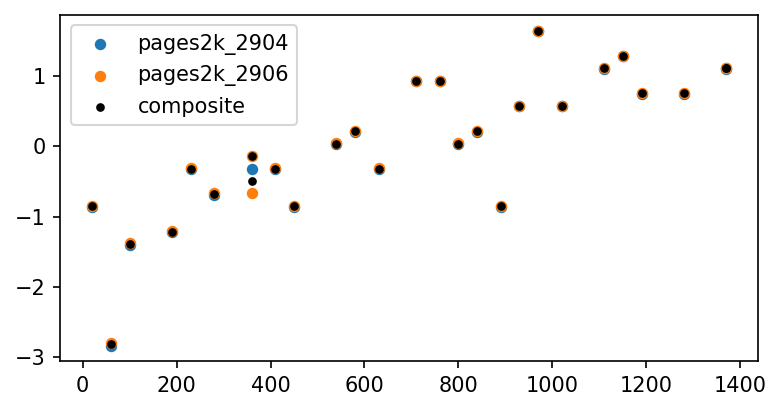

saved figure in /figs//all_merged/dup_detection//composite_pages2k_2904_pages2k_2906.pdf
pages2k_2922 FE23_northamerica_usa_ca603
Add the following note to duplicateDetails: archiveType: Metadata identical
Add the following note to duplicateDetails: archiveType: Metadata identicalgeo_meanElev: Metadata identical
--------------------------------------------------------------------------------
Metadata different for >>>geo_meanLat<<< in: pages2k_2922 (37.9) and FE23_northamerica_usa_ca603 (37.916668). 
Add the following note to duplicateDetails: Metadata differs for geo_meanLat in original records: pages2k_2922 (37.9) and FE23_northamerica_usa_ca603 (37.916668). geo_meanLat: Metadata averaged to: 37.908333
--------------------------------------------------------------------------------
Metadata different for >>>geo_meanLon<<< in: pages2k_2922 (-119.2) and FE23_northamerica_usa_ca603 (-119.23333). 
Add the following note to duplicateDetails: Metadata differs for geo_meanLon in original re

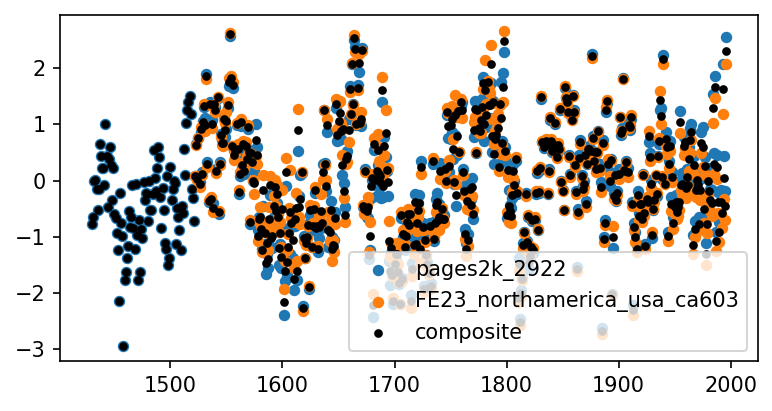

saved figure in /figs//all_merged/dup_detection//composite_pages2k_2922_FE23_northamerica_usa_ca603.pdf
pages2k_2959 FE23_northamerica_mexico_mexi043
Add the following note to duplicateDetails: archiveType: Metadata identical
Add the following note to duplicateDetails: archiveType: Metadata identicalgeo_meanElev: Metadata identical
--------------------------------------------------------------------------------
Metadata different for >>>geo_meanLat<<< in: pages2k_2959 (25.1) and FE23_northamerica_mexico_mexi043 (25.066668). 
Add the following note to duplicateDetails: Metadata differs for geo_meanLat in original records: pages2k_2959 (25.1) and FE23_northamerica_mexico_mexi043 (25.066668). geo_meanLat: Metadata averaged to: 25.083334
Add the following note to duplicateDetails: Metadata differs for geo_meanLat in original records: pages2k_2959 (25.1) and FE23_northamerica_mexico_mexi043 (25.066668). geo_meanLat: Metadata averaged to: 25.083334geo_meanLon: Metadata identical
------------

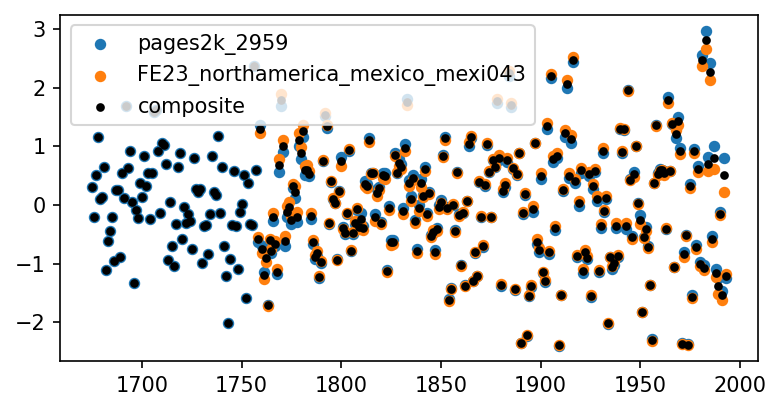

saved figure in /figs//all_merged/dup_detection//composite_pages2k_2959_FE23_northamerica_mexico_mexi043.pdf
pages2k_2976 FE23_northamerica_usa_id008
Add the following note to duplicateDetails: archiveType: Metadata identical
Add the following note to duplicateDetails: archiveType: Metadata identicalgeo_meanElev: Metadata identical
--------------------------------------------------------------------------------
Metadata different for >>>geo_meanLat<<< in: pages2k_2976 (43.9) and FE23_northamerica_usa_id008 (43.866665). 
Add the following note to duplicateDetails: Metadata differs for geo_meanLat in original records: pages2k_2976 (43.9) and FE23_northamerica_usa_id008 (43.866665). geo_meanLat: Metadata averaged to: 43.88333
--------------------------------------------------------------------------------
Metadata different for >>>geo_meanLon<<< in: pages2k_2976 (-114.7) and FE23_northamerica_usa_id008 (-114.71667). 
Add the following note to duplicateDetails: Metadata differs for geo_mea

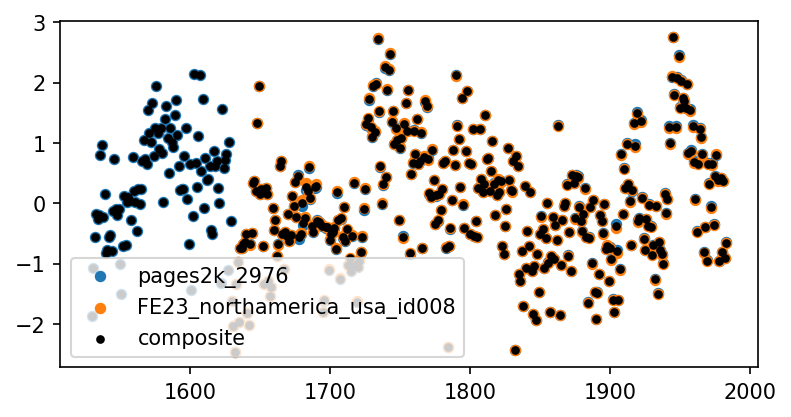

saved figure in /figs//all_merged/dup_detection//composite_pages2k_2976_FE23_northamerica_usa_id008.pdf
pages2k_3002 FE23_northamerica_usa_or043
Add the following note to duplicateDetails: archiveType: Metadata identical
Add the following note to duplicateDetails: archiveType: Metadata identicalgeo_meanElev: Metadata identical
--------------------------------------------------------------------------------
Metadata different for >>>geo_meanLat<<< in: pages2k_3002 (45.3) and FE23_northamerica_usa_or043 (45.316666). 
Add the following note to duplicateDetails: Metadata differs for geo_meanLat in original records: pages2k_3002 (45.3) and FE23_northamerica_usa_or043 (45.316666). geo_meanLat: Metadata averaged to: 45.308334
--------------------------------------------------------------------------------
Metadata different for >>>geo_meanLon<<< in: pages2k_3002 (-121.7) and FE23_northamerica_usa_or043 (-121.65). 
Add the following note to duplicateDetails: Metadata differs for geo_meanLon in

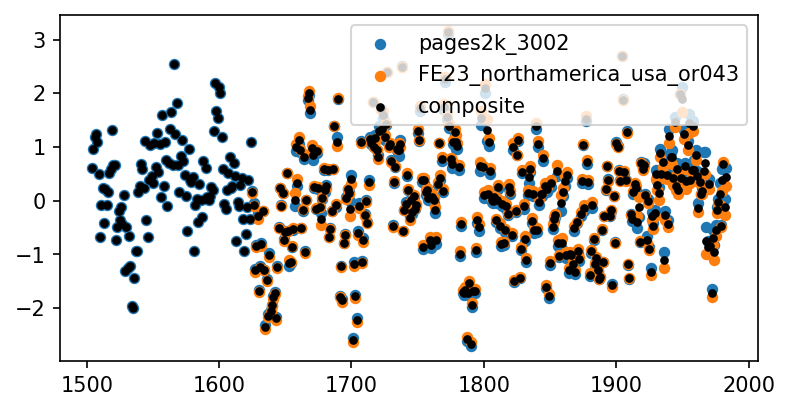

saved figure in /figs//all_merged/dup_detection//composite_pages2k_3002_FE23_northamerica_usa_or043.pdf
pages2k_3038 FE23_northamerica_usa_mt108
Add the following note to duplicateDetails: archiveType: Metadata identical
Add the following note to duplicateDetails: archiveType: Metadata identicalgeo_meanElev: Metadata identical
--------------------------------------------------------------------------------
Metadata different for >>>geo_meanLat<<< in: pages2k_3038 (45.8) and FE23_northamerica_usa_mt108 (45.75). 
Add the following note to duplicateDetails: Metadata differs for geo_meanLat in original records: pages2k_3038 (45.8) and FE23_northamerica_usa_mt108 (45.75). geo_meanLat: Metadata averaged to: 45.775
--------------------------------------------------------------------------------
Metadata different for >>>geo_meanLon<<< in: pages2k_3038 (-112.5) and FE23_northamerica_usa_mt108 (-112.53333). 
Add the following note to duplicateDetails: Metadata differs for geo_meanLon in origina

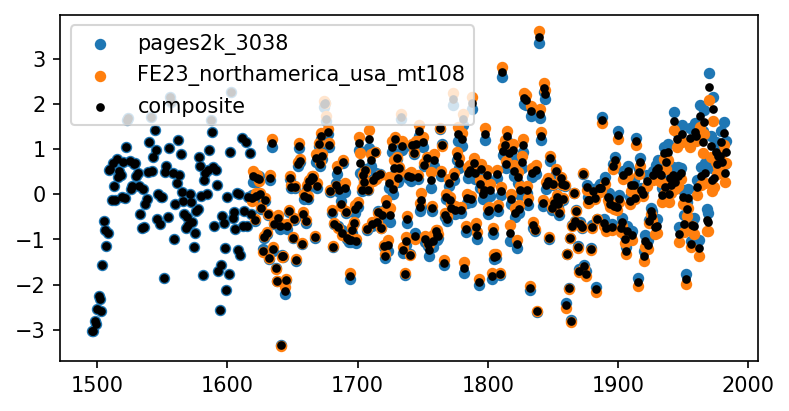

saved figure in /figs//all_merged/dup_detection//composite_pages2k_3038_FE23_northamerica_usa_mt108.pdf
pages2k_3085 iso2k_1556
Add the following note to duplicateDetails: archiveType: Metadata identical
Add the following note to duplicateDetails: archiveType: Metadata identicalgeo_meanElev: Metadata identical
Add the following note to duplicateDetails: archiveType: Metadata identicalgeo_meanElev: Metadata identicalgeo_meanLat: Metadata identical
Add the following note to duplicateDetails: archiveType: Metadata identicalgeo_meanElev: Metadata identicalgeo_meanLat: Metadata identicalgeo_meanLon: Metadata identical
--------------------------------------------------------------------------------
Metadata different for >>>geo_siteName<<< in: pages2k_3085 (Ningaloo) and iso2k_1556 (Ningaloo Reef, West Australia). 
Add the following note to duplicateDetails: Metadata differs for geo_siteName in original records: pages2k_3085 (Ningaloo) and iso2k_1556 (Ningaloo Reef, West Australia). geo_site

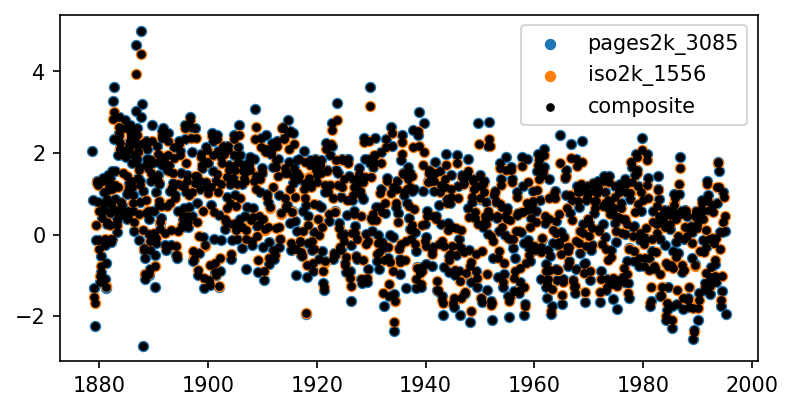

saved figure in /figs//all_merged/dup_detection//composite_pages2k_3085_iso2k_1556.pdf
pages2k_3107 FE23_northamerica_usa_co552
Add the following note to duplicateDetails: archiveType: Metadata identical
Add the following note to duplicateDetails: archiveType: Metadata identicalgeo_meanElev: Metadata identical
Add the following note to duplicateDetails: archiveType: Metadata identicalgeo_meanElev: Metadata identicalgeo_meanLat: Metadata identical
--------------------------------------------------------------------------------
Metadata different for >>>geo_meanLon<<< in: pages2k_3107 (-107.7) and FE23_northamerica_usa_co552 (-107.71667). 
Add the following note to duplicateDetails: Metadata differs for geo_meanLon in original records: pages2k_3107 (-107.7) and FE23_northamerica_usa_co552 (-107.71667). geo_meanLon: Metadata averaged to: -107.70833
--------------------------------------------------------------------------------
Metadata different for >>>geo_siteName<<< in: pages2k_3107 (R

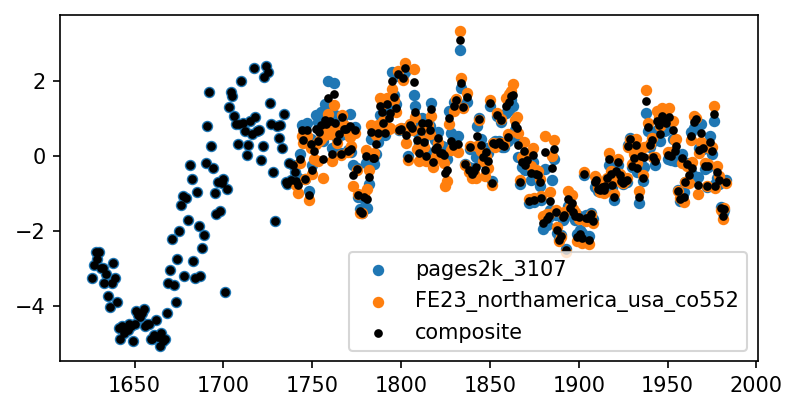

saved figure in /figs//all_merged/dup_detection//composite_pages2k_3107_FE23_northamerica_usa_co552.pdf
pages2k_3108 FE23_northamerica_usa_co552
Add the following note to duplicateDetails: archiveType: Metadata identical
Add the following note to duplicateDetails: archiveType: Metadata identicalgeo_meanElev: Metadata identical
Add the following note to duplicateDetails: archiveType: Metadata identicalgeo_meanElev: Metadata identicalgeo_meanLat: Metadata identical
--------------------------------------------------------------------------------
Metadata different for >>>geo_meanLon<<< in: pages2k_3108 (-107.7) and FE23_northamerica_usa_co552 (-107.71667). 
Add the following note to duplicateDetails: Metadata differs for geo_meanLon in original records: pages2k_3108 (-107.7) and FE23_northamerica_usa_co552 (-107.71667). geo_meanLon: Metadata averaged to: -107.70833
--------------------------------------------------------------------------------
Metadata different for >>>geo_siteName<<< in

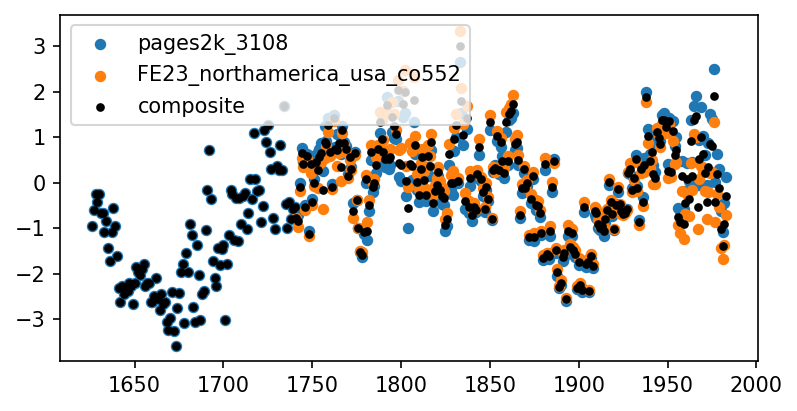

saved figure in /figs//all_merged/dup_detection//composite_pages2k_3108_FE23_northamerica_usa_co552.pdf
pages2k_3179 FE23_northamerica_usa_ak057
Add the following note to duplicateDetails: archiveType: Metadata identical
Add the following note to duplicateDetails: archiveType: Metadata identicalgeo_meanElev: Metadata identical
--------------------------------------------------------------------------------
Metadata different for >>>geo_meanLat<<< in: pages2k_3179 (65.2) and FE23_northamerica_usa_ak057 (65.183334). 
Add the following note to duplicateDetails: Metadata differs for geo_meanLat in original records: pages2k_3179 (65.2) and FE23_northamerica_usa_ak057 (65.183334). geo_meanLat: Metadata averaged to: 65.191666
Add the following note to duplicateDetails: Metadata differs for geo_meanLat in original records: pages2k_3179 (65.2) and FE23_northamerica_usa_ak057 (65.183334). geo_meanLat: Metadata averaged to: 65.191666geo_meanLon: Metadata identical
--------------------------------

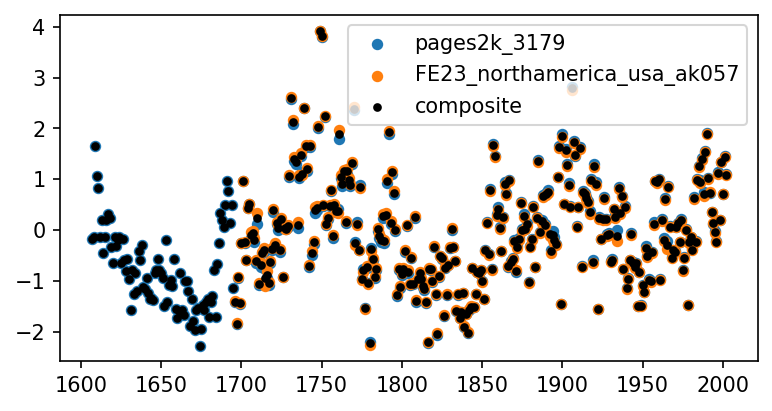

saved figure in /figs//all_merged/dup_detection//composite_pages2k_3179_FE23_northamerica_usa_ak057.pdf
pages2k_3196 FE23_asia_mong011
Add the following note to duplicateDetails: archiveType: Metadata identical
--------------------------------------------------------------------------------
Metadata different for >>>geo_meanElev<<< in: pages2k_3196 (3700.0) and FE23_asia_mong011 (1900.0). 
Add the following note to duplicateDetails: Metadata differs for geo_meanElev in original records: pages2k_3196 (3700.0) and FE23_asia_mong011 (1900.0). geo_meanElev: Metadata averaged to: 2800.0
--------------------------------------------------------------------------------
Metadata different for >>>geo_meanLat<<< in: pages2k_3196 (48.13) and FE23_asia_mong011 (48.15). 
Add the following note to duplicateDetails: Metadata differs for geo_meanLat in original records: pages2k_3196 (48.13) and FE23_asia_mong011 (48.15). geo_meanLat: Metadata averaged to: 48.14
-----------------------------------------

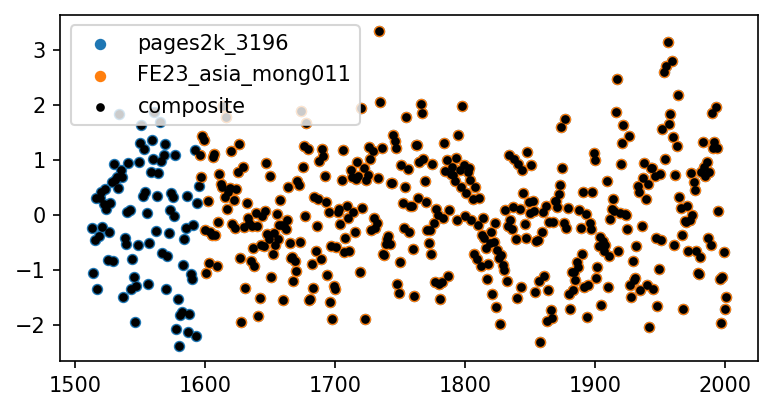

saved figure in /figs//all_merged/dup_detection//composite_pages2k_3196_FE23_asia_mong011.pdf
pages2k_3313 FE23_northamerica_usa_ca560
Add the following note to duplicateDetails: archiveType: Metadata identical
Add the following note to duplicateDetails: archiveType: Metadata identicalgeo_meanElev: Metadata identical
Add the following note to duplicateDetails: archiveType: Metadata identicalgeo_meanElev: Metadata identicalgeo_meanLat: Metadata identical
--------------------------------------------------------------------------------
Metadata different for >>>geo_meanLon<<< in: pages2k_3313 (-119.3) and FE23_northamerica_usa_ca560 (-119.25). 
Add the following note to duplicateDetails: Metadata differs for geo_meanLon in original records: pages2k_3313 (-119.3) and FE23_northamerica_usa_ca560 (-119.25). geo_meanLon: Metadata averaged to: -119.275
--------------------------------------------------------------------------------
Metadata different for >>>geo_siteName<<< in: pages2k_3313 (Yo

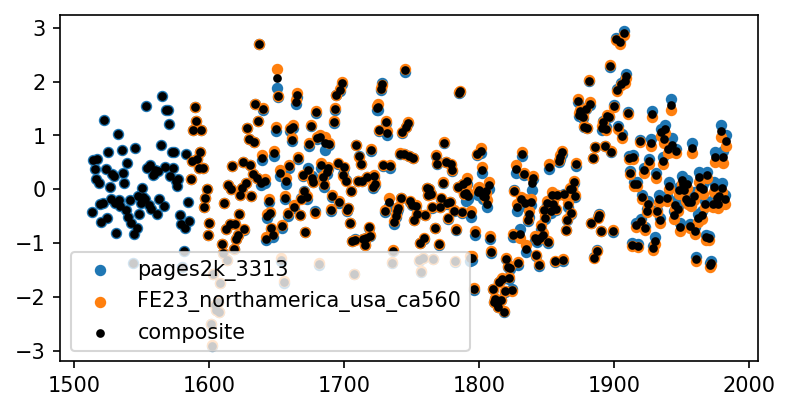

saved figure in /figs//all_merged/dup_detection//composite_pages2k_3313_FE23_northamerica_usa_ca560.pdf
pages2k_3404 FE23_northamerica_canada_cana029
Add the following note to duplicateDetails: archiveType: Metadata identical
Add the following note to duplicateDetails: archiveType: Metadata identicalgeo_meanElev: Metadata identical
--------------------------------------------------------------------------------
Metadata different for >>>geo_meanLat<<< in: pages2k_3404 (68.6) and FE23_northamerica_canada_cana029 (68.63333). 
Add the following note to duplicateDetails: Metadata differs for geo_meanLat in original records: pages2k_3404 (68.6) and FE23_northamerica_canada_cana029 (68.63333). geo_meanLat: Metadata averaged to: 68.61667
--------------------------------------------------------------------------------
Metadata different for >>>geo_meanLon<<< in: pages2k_3404 (-138.6) and FE23_northamerica_canada_cana029 (-138.63333). 
Add the following note to duplicateDetails: Metadata differ

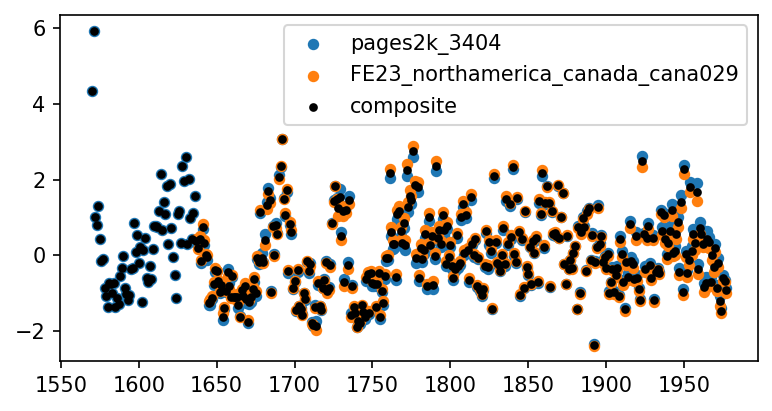

saved figure in /figs//all_merged/dup_detection//composite_pages2k_3404_FE23_northamerica_canada_cana029.pdf
pages2k_3503 FE23_northamerica_usa_wa072
Add the following note to duplicateDetails: archiveType: Metadata identical
Add the following note to duplicateDetails: archiveType: Metadata identicalgeo_meanElev: Metadata identical
--------------------------------------------------------------------------------
Metadata different for >>>geo_meanLat<<< in: pages2k_3503 (48.7) and FE23_northamerica_usa_wa072 (48.733334). 
Add the following note to duplicateDetails: Metadata differs for geo_meanLat in original records: pages2k_3503 (48.7) and FE23_northamerica_usa_wa072 (48.733334). geo_meanLat: Metadata averaged to: 48.716667
--------------------------------------------------------------------------------
Metadata different for >>>geo_meanLon<<< in: pages2k_3503 (-120.7) and FE23_northamerica_usa_wa072 (-120.65). 
Add the following note to duplicateDetails: Metadata differs for geo_meanL

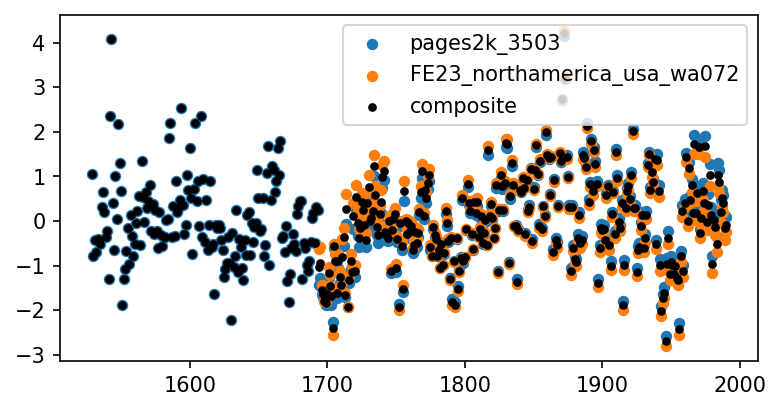

saved figure in /figs//all_merged/dup_detection//composite_pages2k_3503_FE23_northamerica_usa_wa072.pdf
pages2k_3524 FE23_northamerica_usa_ak010
Add the following note to duplicateDetails: archiveType: Metadata identical
Add the following note to duplicateDetails: archiveType: Metadata identicalgeo_meanElev: Metadata identical
--------------------------------------------------------------------------------
Metadata different for >>>geo_meanLat<<< in: pages2k_3524 (61.8) and FE23_northamerica_usa_ak010 (61.833332). 
Add the following note to duplicateDetails: Metadata differs for geo_meanLat in original records: pages2k_3524 (61.8) and FE23_northamerica_usa_ak010 (61.833332). geo_meanLat: Metadata averaged to: 61.816666
--------------------------------------------------------------------------------
Metadata different for >>>geo_meanLon<<< in: pages2k_3524 (-147.3) and FE23_northamerica_usa_ak010 (-147.33333). 
Add the following note to duplicateDetails: Metadata differs for geo_meanLon

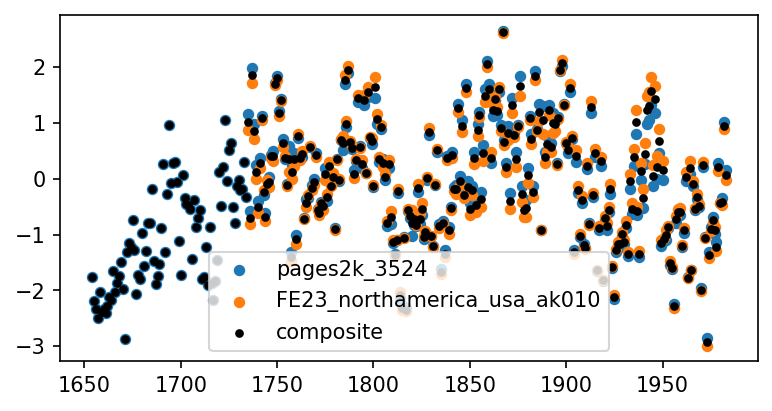

saved figure in /figs//all_merged/dup_detection//composite_pages2k_3524_FE23_northamerica_usa_ak010.pdf
pages2k_3550 FE23_asia_russ137w
Add the following note to duplicateDetails: archiveType: Metadata identical
Add the following note to duplicateDetails: archiveType: Metadata identicalgeo_meanElev: Metadata identical
--------------------------------------------------------------------------------
Metadata different for >>>geo_meanLat<<< in: pages2k_3550 (50.48) and FE23_asia_russ137w (50.483334). 
Add the following note to duplicateDetails: Metadata differs for geo_meanLat in original records: pages2k_3550 (50.48) and FE23_asia_russ137w (50.483334). geo_meanLat: Metadata averaged to: 50.481667
Add the following note to duplicateDetails: Metadata differs for geo_meanLat in original records: pages2k_3550 (50.48) and FE23_asia_russ137w (50.483334). geo_meanLat: Metadata averaged to: 50.481667geo_meanLon: Metadata identical
-----------------------------------------------------------------

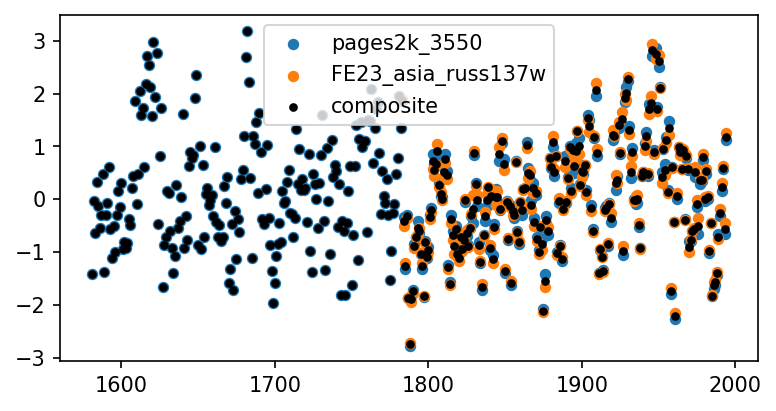

saved figure in /figs//all_merged/dup_detection//composite_pages2k_3550_FE23_asia_russ137w.pdf
pages2k_3583 FE23_northamerica_usa_co633
Add the following note to duplicateDetails: archiveType: Metadata identical
Add the following note to duplicateDetails: archiveType: Metadata identicalgeo_meanElev: Metadata identical
--------------------------------------------------------------------------------
Metadata different for >>>geo_meanLat<<< in: pages2k_3583 (40.6) and FE23_northamerica_usa_co633 (40.55). 
Add the following note to duplicateDetails: Metadata differs for geo_meanLat in original records: pages2k_3583 (40.6) and FE23_northamerica_usa_co633 (40.55). geo_meanLat: Metadata averaged to: 40.574997
--------------------------------------------------------------------------------
Metadata different for >>>geo_meanLon<<< in: pages2k_3583 (-105.8) and FE23_northamerica_usa_co633 (-105.833336). 
Add the following note to duplicateDetails: Metadata differs for geo_meanLon in original rec

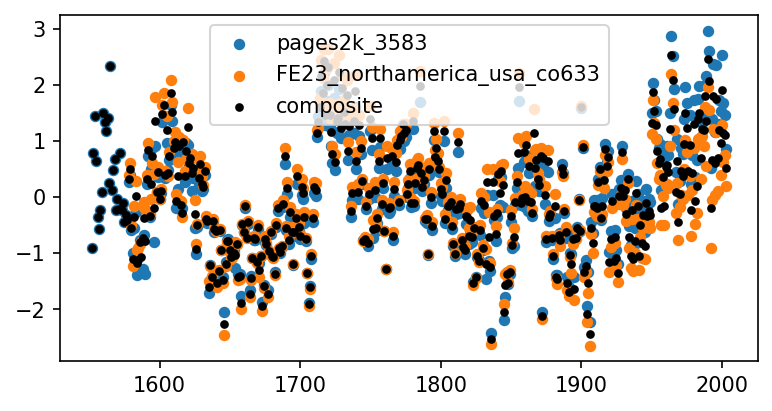

saved figure in /figs//all_merged/dup_detection//composite_pages2k_3583_FE23_northamerica_usa_co633.pdf
pages2k_3642 FE23_northamerica_usa_wy025
Add the following note to duplicateDetails: archiveType: Metadata identical
Add the following note to duplicateDetails: archiveType: Metadata identicalgeo_meanElev: Metadata identical
--------------------------------------------------------------------------------
Metadata different for >>>geo_meanLat<<< in: pages2k_3642 (43.7) and FE23_northamerica_usa_wy025 (43.716667). 
Add the following note to duplicateDetails: Metadata differs for geo_meanLat in original records: pages2k_3642 (43.7) and FE23_northamerica_usa_wy025 (43.716667). geo_meanLat: Metadata averaged to: 43.708336
--------------------------------------------------------------------------------
Metadata different for >>>geo_meanLon<<< in: pages2k_3642 (-110.1) and FE23_northamerica_usa_wy025 (-110.05). 
Add the following note to duplicateDetails: Metadata differs for geo_meanLon in

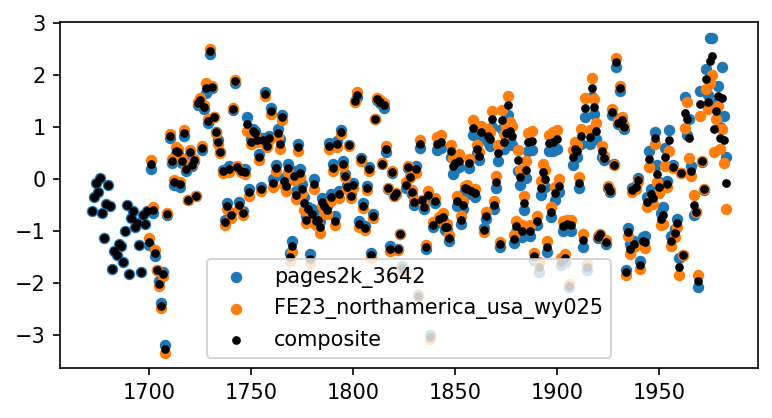

saved figure in /figs//all_merged/dup_detection//composite_pages2k_3642_FE23_northamerica_usa_wy025.pdf
FE23_europe_swed019w FE23_europe_swed021w
Add the following note to duplicateDetails: archiveType: Metadata identical
Add the following note to duplicateDetails: archiveType: Metadata identicalgeo_meanElev: Metadata identical
Add the following note to duplicateDetails: archiveType: Metadata identicalgeo_meanElev: Metadata identicalgeo_meanLat: Metadata identical
Add the following note to duplicateDetails: archiveType: Metadata identicalgeo_meanElev: Metadata identicalgeo_meanLat: Metadata identicalgeo_meanLon: Metadata identical
--------------------------------------------------------------------------------
Metadata different for >>>geo_siteName<<< in: FE23_europe_swed019w (Torneträskr+f.,Bartoli) and FE23_europe_swed021w (Torneträskfos.,Bartoli). 
Add the following note to duplicateDetails: Metadata differs for geo_siteName in original records: FE23_europe_swed019w (Torneträskr+f.,

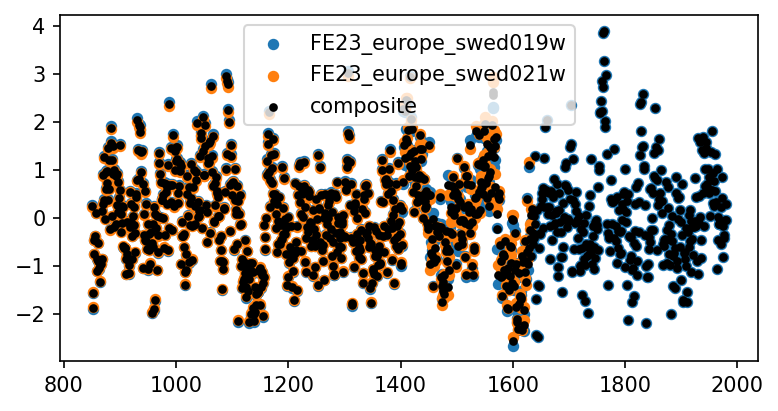

saved figure in /figs//all_merged/dup_detection//composite_FE23_europe_swed019w_FE23_europe_swed021w.pdf
FE23_northamerica_mexico_mexi022 FE23_northamerica_mexico_mexi023
Add the following note to duplicateDetails: archiveType: Metadata identical
Add the following note to duplicateDetails: archiveType: Metadata identicalgeo_meanElev: Metadata identical
Add the following note to duplicateDetails: archiveType: Metadata identicalgeo_meanElev: Metadata identicalgeo_meanLat: Metadata identical
Add the following note to duplicateDetails: archiveType: Metadata identicalgeo_meanElev: Metadata identicalgeo_meanLat: Metadata identicalgeo_meanLon: Metadata identical
--------------------------------------------------------------------------------
Metadata different for >>>geo_siteName<<< in: FE23_northamerica_mexico_mexi022 (CerroBaraja) and FE23_northamerica_mexico_mexi023 (CerroBarajaandLosAngelesSawmill). 
Add the following note to duplicateDetails: Metadata differs for geo_siteName in original

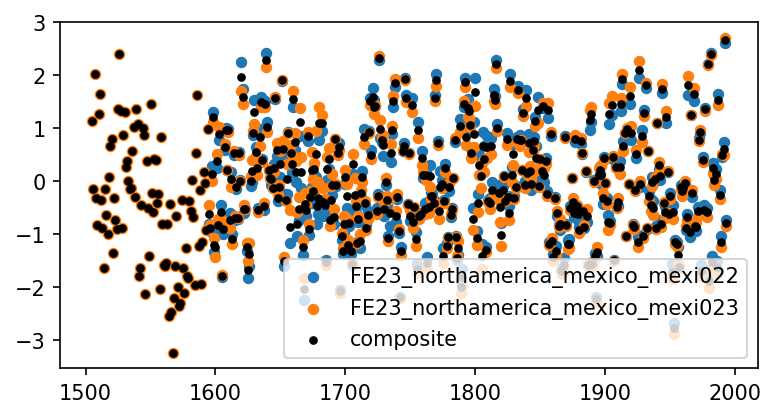

saved figure in /figs//all_merged/dup_detection//composite_FE23_northamerica_mexico_mexi022_FE23_northamerica_mexico_mexi023.pdf
FE23_australia_newz008 FE23_australia_newz092
Add the following note to duplicateDetails: archiveType: Metadata identical
Add the following note to duplicateDetails: archiveType: Metadata identicalgeo_meanElev: Metadata identical
Add the following note to duplicateDetails: archiveType: Metadata identicalgeo_meanElev: Metadata identicalgeo_meanLat: Metadata identical
Add the following note to duplicateDetails: archiveType: Metadata identicalgeo_meanElev: Metadata identicalgeo_meanLat: Metadata identicalgeo_meanLon: Metadata identical
Add the following note to duplicateDetails: archiveType: Metadata identicalgeo_meanElev: Metadata identicalgeo_meanLat: Metadata identicalgeo_meanLon: Metadata identicalgeo_siteName: Metadata identical
Add the following note to duplicateDetails: archiveType: Metadata identicalgeo_meanElev: Metadata identicalgeo_meanLat: Metadata i

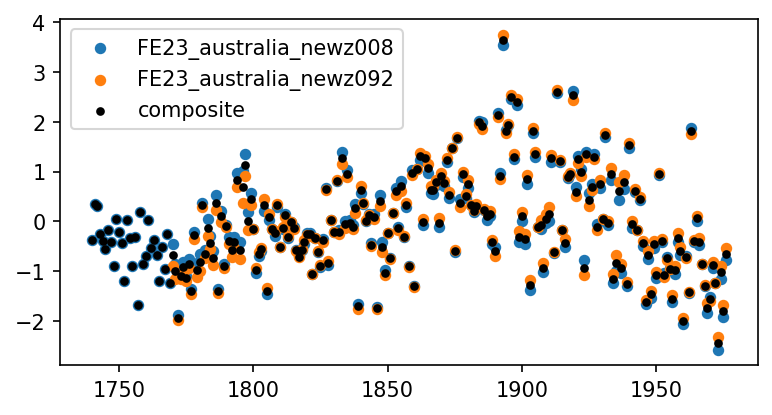

saved figure in /figs//all_merged/dup_detection//composite_FE23_australia_newz008_FE23_australia_newz092.pdf
FE23_northamerica_usa_ca512 FE23_northamerica_usa_ca613
Add the following note to duplicateDetails: archiveType: Metadata identical
Add the following note to duplicateDetails: archiveType: Metadata identicalgeo_meanElev: Metadata identical
Add the following note to duplicateDetails: archiveType: Metadata identicalgeo_meanElev: Metadata identicalgeo_meanLat: Metadata identical
Add the following note to duplicateDetails: archiveType: Metadata identicalgeo_meanElev: Metadata identicalgeo_meanLat: Metadata identicalgeo_meanLon: Metadata identical
--------------------------------------------------------------------------------
Metadata different for >>>geo_siteName<<< in: FE23_northamerica_usa_ca512 (SantaAna) and FE23_northamerica_usa_ca613 (SantaAnaMts.(NewandOld)). 
Add the following note to duplicateDetails: Metadata differs for geo_siteName in original records: FE23_northamerica

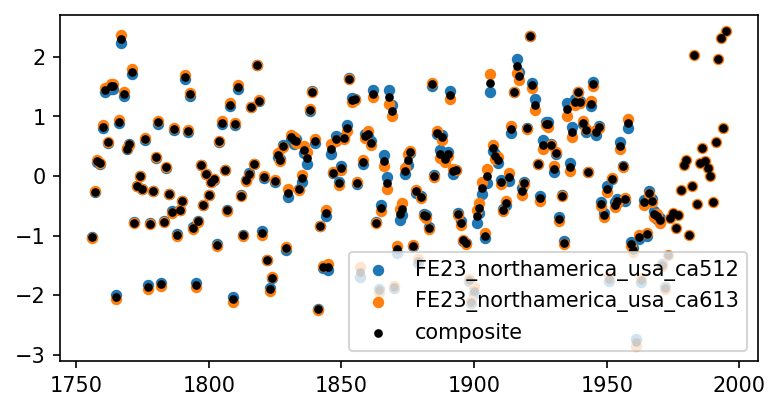

saved figure in /figs//all_merged/dup_detection//composite_FE23_northamerica_usa_ca512_FE23_northamerica_usa_ca613.pdf
FE23_northamerica_usa_me017 FE23_northamerica_usa_me018
Add the following note to duplicateDetails: archiveType: Metadata identical
Add the following note to duplicateDetails: archiveType: Metadata identicalgeo_meanElev: Metadata identical
Add the following note to duplicateDetails: archiveType: Metadata identicalgeo_meanElev: Metadata identicalgeo_meanLat: Metadata identical
Add the following note to duplicateDetails: archiveType: Metadata identicalgeo_meanElev: Metadata identicalgeo_meanLat: Metadata identicalgeo_meanLon: Metadata identical
--------------------------------------------------------------------------------
Metadata different for >>>geo_siteName<<< in: FE23_northamerica_usa_me017 (IronboundIsland) and FE23_northamerica_usa_me018 (IronboundIslandLongCores). 
Add the following note to duplicateDetails: Metadata differs for geo_siteName in original records:

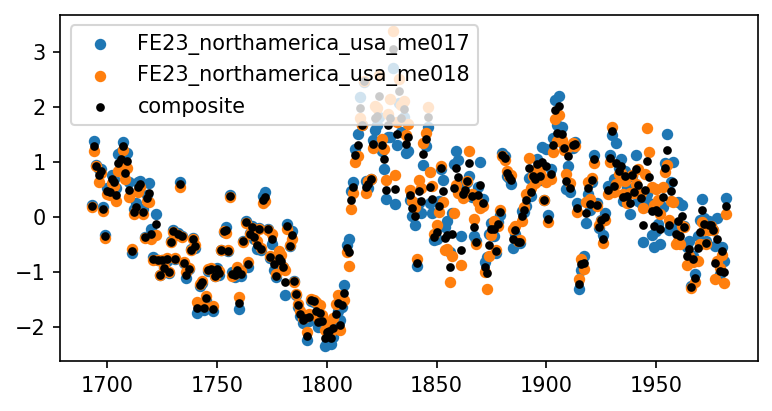

saved figure in /figs//all_merged/dup_detection//composite_FE23_northamerica_usa_me017_FE23_northamerica_usa_me018.pdf
FE23_northamerica_usa_mt112 FE23_northamerica_usa_mt113
Add the following note to duplicateDetails: archiveType: Metadata identical
Add the following note to duplicateDetails: archiveType: Metadata identicalgeo_meanElev: Metadata identical
Add the following note to duplicateDetails: archiveType: Metadata identicalgeo_meanElev: Metadata identicalgeo_meanLat: Metadata identical
Add the following note to duplicateDetails: archiveType: Metadata identicalgeo_meanElev: Metadata identicalgeo_meanLat: Metadata identicalgeo_meanLon: Metadata identical
--------------------------------------------------------------------------------
Metadata different for >>>geo_siteName<<< in: FE23_northamerica_usa_mt112 (YellowMountainRidge1) and FE23_northamerica_usa_mt113 (YellowMountainRidge1-EntireBarkTrees). 
Add the following note to duplicateDetails: Metadata differs for geo_siteName in 

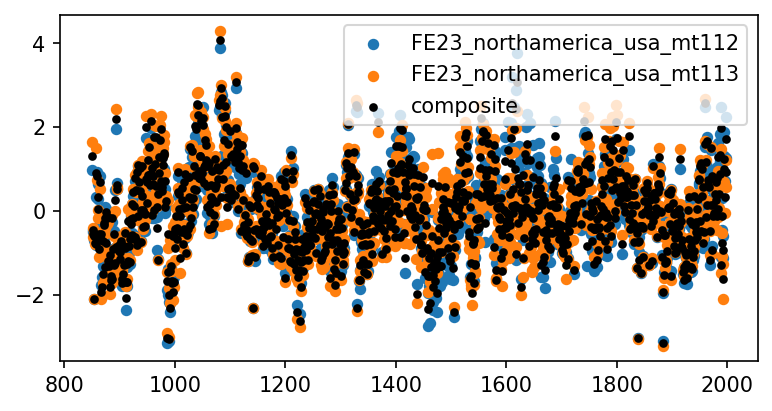

saved figure in /figs//all_merged/dup_detection//composite_FE23_northamerica_usa_mt112_FE23_northamerica_usa_mt113.pdf
FE23_northamerica_usa_nj001 FE23_northamerica_usa_nj002
Add the following note to duplicateDetails: archiveType: Metadata identical
Add the following note to duplicateDetails: archiveType: Metadata identicalgeo_meanElev: Metadata identical
Add the following note to duplicateDetails: archiveType: Metadata identicalgeo_meanElev: Metadata identicalgeo_meanLat: Metadata identical
Add the following note to duplicateDetails: archiveType: Metadata identicalgeo_meanElev: Metadata identicalgeo_meanLat: Metadata identicalgeo_meanLon: Metadata identical
--------------------------------------------------------------------------------
Metadata different for >>>geo_siteName<<< in: FE23_northamerica_usa_nj001 (HutchensonForestwithLongCores) and FE23_northamerica_usa_nj002 (HutchensonForest). 
Add the following note to duplicateDetails: Metadata differs for geo_siteName in original re

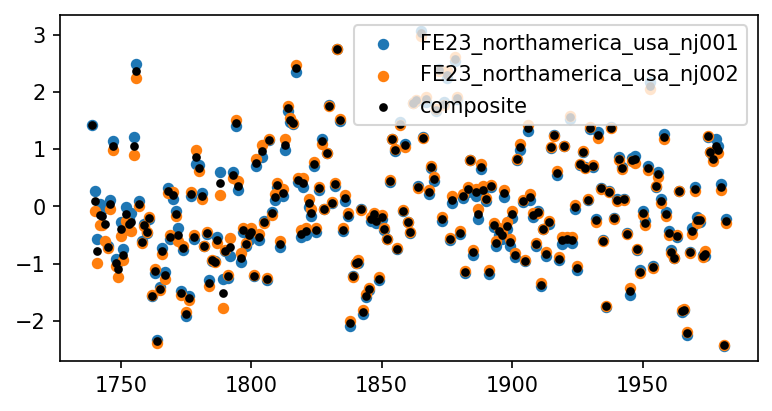

saved figure in /figs//all_merged/dup_detection//composite_FE23_northamerica_usa_nj001_FE23_northamerica_usa_nj002.pdf
ch2k_KU99HOU01_40 iso2k_788
Add the following note to duplicateDetails: archiveType: Metadata identical
Add the following note to duplicateDetails: archiveType: Metadata identicalgeo_meanElev: Metadata identical
Add the following note to duplicateDetails: archiveType: Metadata identicalgeo_meanElev: Metadata identicalgeo_meanLat: Metadata identical
Add the following note to duplicateDetails: archiveType: Metadata identicalgeo_meanElev: Metadata identicalgeo_meanLat: Metadata identicalgeo_meanLon: Metadata identical
--------------------------------------------------------------------------------
Metadata different for >>>geo_siteName<<< in: ch2k_KU99HOU01_40 (Houtman Abrolhos Islands, Australia) and iso2k_788 (Houtman Abrolhos Islands). 
Add the following note to duplicateDetails: Metadata differs for geo_siteName in original records: ch2k_KU99HOU01_40 (Houtman Abrolhos

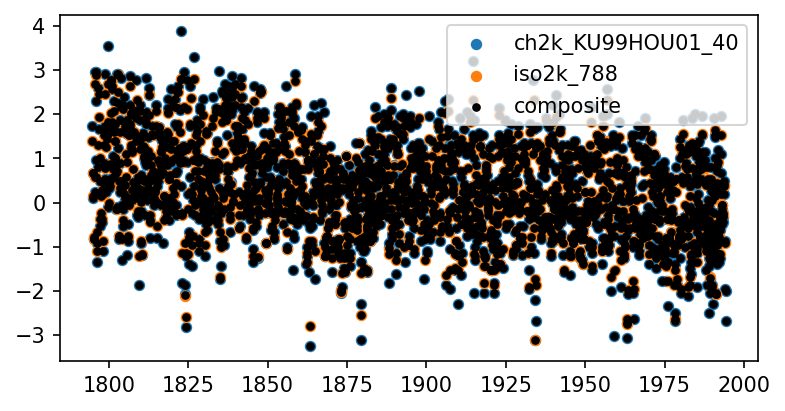

saved figure in /figs//all_merged/dup_detection//composite_ch2k_KU99HOU01_40_iso2k_788.pdf
ch2k_KU00NIN01_150 iso2k_1556
Add the following note to duplicateDetails: archiveType: Metadata identical
Add the following note to duplicateDetails: archiveType: Metadata identicalgeo_meanElev: Metadata identical
Add the following note to duplicateDetails: archiveType: Metadata identicalgeo_meanElev: Metadata identicalgeo_meanLat: Metadata identical
Add the following note to duplicateDetails: archiveType: Metadata identicalgeo_meanElev: Metadata identicalgeo_meanLat: Metadata identicalgeo_meanLon: Metadata identical
--------------------------------------------------------------------------------
Metadata different for >>>geo_siteName<<< in: ch2k_KU00NIN01_150 (Ningaloo Reef, Australia) and iso2k_1556 (Ningaloo Reef, West Australia). 
Add the following note to duplicateDetails: Metadata differs for geo_siteName in original records: ch2k_KU00NIN01_150 (Ningaloo Reef, Australia) and iso2k_1556 (Nin

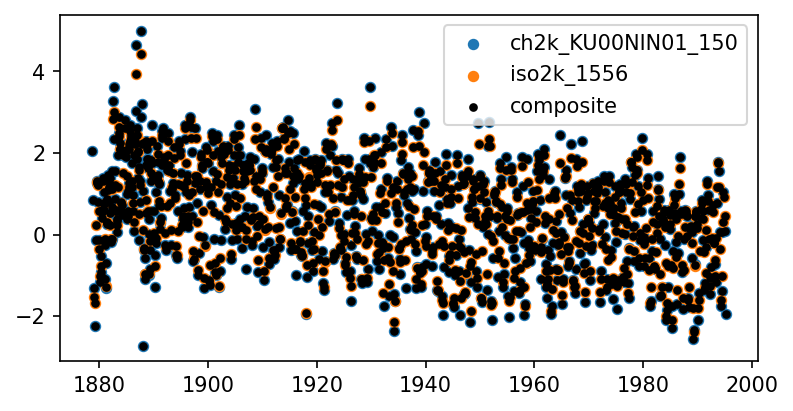

saved figure in /figs//all_merged/dup_detection//composite_ch2k_KU00NIN01_150_iso2k_1556.pdf
iso2k_786 iso2k_788
Add the following note to duplicateDetails: archiveType: Metadata identical
Add the following note to duplicateDetails: archiveType: Metadata identicalgeo_meanElev: Metadata identical
Add the following note to duplicateDetails: archiveType: Metadata identicalgeo_meanElev: Metadata identicalgeo_meanLat: Metadata identical
Add the following note to duplicateDetails: archiveType: Metadata identicalgeo_meanElev: Metadata identicalgeo_meanLat: Metadata identicalgeo_meanLon: Metadata identical
Add the following note to duplicateDetails: archiveType: Metadata identicalgeo_meanElev: Metadata identicalgeo_meanLat: Metadata identicalgeo_meanLon: Metadata identicalgeo_siteName: Metadata identical
Add the following note to duplicateDetails: archiveType: Metadata identicalgeo_meanElev: Metadata identicalgeo_meanLat: Metadata identicalgeo_meanLon: Metadata identicalgeo_siteName: Metadata 

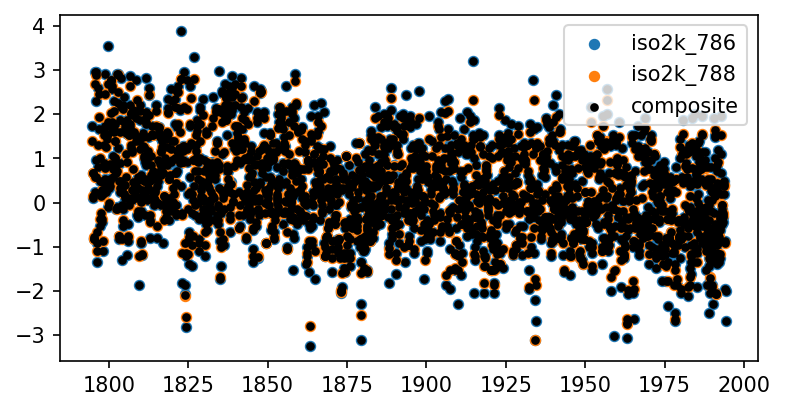

saved figure in /figs//all_merged/dup_detection//composite_iso2k_786_iso2k_788.pdf
iso2k_1554 iso2k_1556
Add the following note to duplicateDetails: archiveType: Metadata identical
Add the following note to duplicateDetails: archiveType: Metadata identicalgeo_meanElev: Metadata identical
Add the following note to duplicateDetails: archiveType: Metadata identicalgeo_meanElev: Metadata identicalgeo_meanLat: Metadata identical
Add the following note to duplicateDetails: archiveType: Metadata identicalgeo_meanElev: Metadata identicalgeo_meanLat: Metadata identicalgeo_meanLon: Metadata identical
Add the following note to duplicateDetails: archiveType: Metadata identicalgeo_meanElev: Metadata identicalgeo_meanLat: Metadata identicalgeo_meanLon: Metadata identicalgeo_siteName: Metadata identical
Add the following note to duplicateDetails: archiveType: Metadata identicalgeo_meanElev: Metadata identicalgeo_meanLat: Metadata identicalgeo_meanLon: Metadata identicalgeo_siteName: Metadata identica

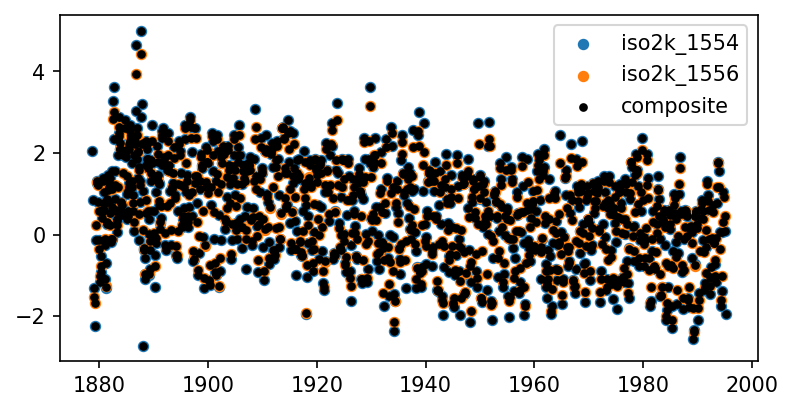

saved figure in /figs//all_merged/dup_detection//composite_iso2k_1554_iso2k_1556.pdf


In [12]:
# add the column 'duplicateDetails' to df, in case it does not exist
if 'duplicateDetails' not in df.columns: df['duplicateDetails']='N/A'

# load the records to be composited
comp_ID_pairs = df_decisions[(df_decisions['Decision 1']=='COMPOSITE')&(df_decisions['Decision 2']=='COMPOSITE')]

# create new composite data and metadata from the pairs
# loop through the composite pairs and check metadata
df_composite = dup.join_composites_metadata(df, comp_ID_pairs, df_decisions, header)

### 3. Check for overlap between REMOVE and COMPOSITE

The duplicate free dataframe is obtained by joining 
- `df_dupfree_rmv` (duplicate free as all records with decision `REMOVE` and/or `COMPOSITE` removed) and
- `df_composite` (dupicate free as duplicates are composited)

There might still be duplicates between the two dataframes: when a record has been associated with more than 1 duplicate candidate pair.

The scenarios for duplicates appearing twice:


1. `REMOVE`/`KEEP` and `COMPOSITE`:
  - duplicate pair `a` and `b` have had the decisions assigned: `a`-> `REMOVE`, `b` -> `KEEP`
  - duplicate pair `a` and `c` have had the decisions assigned: `a` -> `COMPOSITE`, `c` -> `COMPOSITE`.
    
  In this case, `b` and `ac` (the composite record of `a` and `c`) would be <span style="color:red">**duplicates in the merged dataframe**</span>
   
2a. `REMOVE`/`KEEP` & `KEEP`/`REMOVE`:

  - duplicate pair `a` and `b` have had the decisions assigned: `a`-> `REMOVE`, `b` -> `KEEP`
  - duplicate pair `a` and `c` have had the decisions assigned: `a` -> `KEEP`, `c` -> `REMOVE`.
    
    In this case `a` would still be removed as `REMOVE` overrides `KEEP` in the algorithm. So only `b` will be kept and <span style="color:green">**no duplicates would remain**</span>.

2b. `REMOVE`/`KEEP` & `REMOVE`/`KEEP`

  - duplicate pair `a` and `b` have had the decisions assigned: `a`-> `REMOVE`, `b` -> `KEEP`
  - duplicate pair `a` and `c` have had the decisions assigned: `a` -> `REMOVE`, `c` -> `KEEP`.

    In this case, `a` would be removed, but `b` and `c` will be kept and would be <span style="color:red">**duplicates in the merged dataframe**</span>. 

3. `COMPOSITE` x 2
  - duplicate pair `a` and `b` have had the decisions assigned: `a`-> `COMPOSITE`, `b` -> `COMPOSITE`
  - duplicate pair `a` and `c` have had the decisions assigned: `a` -> `COMPOSITE`, `c` -> `COMPOSITE`.

  In this case, `ab` and `ac` would be <span style="color:red">**duplicates in the merged dataframe**</span>.


4. `REMOVE`/`KEEP` and `KEEP`/`KEEP`
- duplicate pair `a` and `b` have had the decisions assigned: `a`-> `REMOVE`, `b` -> `KEEP`
- duplicate pair `a` and `c` have had the decisions assigned: `a` -> `KEEP`, `c` -> `KEEP`.

  In this case `a` would be removed, `b` and `c` would be kept but as `c` is not a duplicate of `a` <span style="color:green">**no duplicates would remain**</span>.

**What about records which appear more than twice?**
These records would not be dealt with by the following approach, as this only removes duplciates which appear TWICE in the dataset. 

The algorithm is currently NOT handling multiple duplicate records. In order to do this, we'd have to set up a WHILE loop which runs UNTIL no duplicate has been assigned to more than one decision! Doable!

Merge the composites and the dataframe freed from REMOVE and COMPOSITE type records

In [27]:
df_duprmv_cmp = pd.concat([df_dupfree_rmv, df_composite])
df_duprmv_cmp.index = df_duprmv_cmp['datasetId']

Check for overlap between REMOVE and COMPOSITE type IDs

In [28]:
overlap_rmv_cmp = []
for id in decisions.keys():
    if ('REMOVE' in decisions[id])&('COMPOSITE' in decisions[id]):
        overlap_rmv_cmp.append(id)
if len(overlap_rmv_cmp)>0:
    print('WARNING! Overlap detected between REMOVE and COMPOSITE records.')
    print('Please review these records below.')
else:
    print('No overlap between REMOVE and COMPOSITE type records.')

WARNING! Overlap detected between REMOVE and COMPOSITE records.
Please review these records below.


In [29]:
check_for_dups = []
for id in overlap_rmv_cmp:
    check_decisions = df_decisions[(df_decisions['datasetId 1']==id)|(df_decisions['datasetId 2']==id)][['datasetId 1', 'datasetId 2', 'Decision 1', 'Decision 2']]
    # print(check_decisions)
    for ind in check_decisions.index:
        dec1, dec2 = check_decisions.loc[ind, ['Decision 1', 'Decision 2']]
        id1, id2   = check_decisions.loc[ind, ['datasetId 1', 'datasetId 2']]
        if dec1=='KEEP':
            check_for_dups.append(id1)
        if dec2=='KEEP':
            check_for_dups.append(id2)
print(check_for_dups)

['pages2k_468', 'pages2k_1089', 'pages2k_1089', 'pages2k_2793', 'pages2k_2796', 'ch2k_KU00NIN01_150', 'iso2k_1554', 'ch2k_KU00NIN01_150', 'iso2k_1554', 'iso2k_786']


Now we create a small dataframe which needs to be checked for duplicates.

In [30]:
df_check=df.loc[check_for_dups]
df_check = pd.concat([df_composite, df_check])
df_check.name = 'tmp'

We then run a brief duplicate detection algorithm on the dataframe. Note that by default the composited data has the highest value in the hierarchy.

In [32]:
dup.find_duplicates_optimized(df_check, n_points_thresh=10)

df_check['Hierarchy'] = 0 
df_check.loc[df_check['originalDatabase']=='PAGES2k v2.2.0', 'Hierarchy'] = 5
df_check.loc[df_check['originalDatabase']=='FE23 (Breitenmoser et al. (2014))', 'Hierarchy'] = 4
df_check.loc[df_check['originalDatabase']=='CoralHydro2k v1.0.1', 'Hierarchy'] = 2
df_check.loc[df_check['originalDatabase']=='Iso2k v1.1.2', 'Hierarchy'] = 3
df_check.loc[df_check['originalDatabase']=='SISAL v3', 'Hierarchy'] = 1

dup.duplicate_decisions(df_check, operator_details=operator_details, choose_recollection=True, 
                        remove_identicals=True)

tmp
Start duplicate search:
checking parameters:
proxy archive                  :  must match     
proxy type                     :  must match     
distance (km)                  < 8               
elevation                      :  must match     
time overlap                   > 10              
correlation                    > 0.9             
RMSE                           < 0.1             
1st difference rmse            < 0.1             
correlation of 1st difference  > 0.9             
Start duplicate search
Progress: 0/48
--> Found potential duplicate: 2: dod2k_composite_z_pages2k_468_pages2k_3550&24: dod2k_composite_z_pages2k_3550_fe23_asia_russ137w (n_potential_duplicates=1)
--> Found potential duplicate: 2: dod2k_composite_z_pages2k_468_pages2k_3550&38: pages2k_468 (n_potential_duplicates=2)
--> Found potential duplicate: 5: dod2k_composite_z_pages2k_2795_pages2k_2798&41: pages2k_2793 (n_potential_duplicates=3)
--> Found potential duplicate: 5: dod2k_composite_z_pages2k_279

Found backup file (data/tmp/dup_detection/dup_decisions_tmp_LL_BACKUP.csv). Do you want to start decision process from the backup file? [y/n] y


header [' Decisions for duplicate candidate pairs. ', ' Operated by Lucie Luecke (LL)', ' E-Mail: ljluec1@st-andrews.ac.uk', ' Created on: 2025-11-11 15:00:09.281159 (UTC)', 'index 1']
data [['2', '24', 'https://nzero.umd.edu:444/hub/user-redirect/lab/tree/compile_proxy_database_v2.1/tmp/dup_detection/000_dod2k_composite_z_pages2k_468_pages2k_3550_dod2k_composite_z_pages2k_3550_FE23_asia_russ137w__2_24.jpg', 'dod2k_composite_z_pages2k_468_pages2k_3550', 'dod2k_composite_z_pages2k_3550_FE23_asia_russ137w', 'dod2k_composite_z', 'dod2k_composite_z', 'Altai Mt., Ust Ulagan Lake', 'COMPOSITE: Altai Mt., Ust Ulagan Lake + UstUlaganLake(Altai)', '50.47999954223633', '50.481666564941406', '87.6500015258789', '87.6500015258789', '2150.0', '2150.0', 'Wood', 'Wood', 'ring width', 'ring width', 'pages2k_468: https://www.ncdc.noaa.gov/paleo/study/4710, pages2k_3550: https://www.ncdc.noaa.gov/paleo/study/4710', 'pages2k_3550: https://www.ncdc.noaa.gov/paleo/study/4710, FE23_asia_russ137w: https://ww

Type your comment on your decision process here and/or press enter: 


(30, 27)
Saved the decisions under data/tmp/dup_detection/dup_decisions_tmp_LL_25-11-11.csv
Summary of all decisions made:
#0: KEEP record dod2k_composite_z_pages2k_468_pages2k_3550. REMOVE record dod2k_composite_z_pages2k_3550_FE23_asia_russ137w.
#1: KEEP record dod2k_composite_z_pages2k_468_pages2k_3550. REMOVE record pages2k_468.
#2: KEEP record dod2k_composite_z_pages2k_2795_pages2k_2798. REMOVE record pages2k_2793.
#3: KEEP record dod2k_composite_z_pages2k_2795_pages2k_2798. KEEP record pages2k_2796.
#4: KEEP record dod2k_composite_z_pages2k_3085_iso2k_1556. REMOVE record dod2k_composite_z_ch2k_KU00NIN01_150_iso2k_1556.
#5: KEEP record dod2k_composite_z_pages2k_3085_iso2k_1556. REMOVE record dod2k_composite_z_iso2k_1554_iso2k_1556.
#6: COMPOSITE record dod2k_composite_z_pages2k_3085_iso2k_1556. COMPOSITE record ch2k_KU00NIN01_150.
#7: KEEP record dod2k_composite_z_pages2k_3085_iso2k_1556. REMOVE record iso2k_1554.
#8: KEEP record dod2k_composite_z_pages2k_3085_iso2k_1556. REMOVE r

Implement the decisions. 

In [43]:
tmp_df_decisions  = pd.read_csv(f'data/{df_check.name}/dup_detection/dup_decisions_{df_check.name}_{initials}_{date}'+'.csv', header=5)
tmp_dup_details   = dup.provide_dup_details(tmp_df_decisions, header)

#drop all REMOVE or COMPOSITE types
tmp_remove_IDs  = list(tmp_df_decisions['datasetId 1'][np.isin(tmp_df_decisions['Decision 1'],['REMOVE', 'COMPOSITE'])])
tmp_remove_IDs += list(tmp_df_decisions['datasetId 2'][np.isin(tmp_df_decisions['Decision 2'],['REMOVE', 'COMPOSITE'])])
tmp_remove_IDs = [id for id in np.unique(tmp_remove_IDs) if id not in remove_IDs]
tmp_df_dupfree_rmv = df_duprmv_cmp.drop(tmp_remove_IDs) # df freed from 'REMOVE' type duplicates

# # composite the 
tmp_comp_ID_pairs = tmp_df_decisions[(tmp_df_decisions['Decision 1']=='COMPOSITE')&(tmp_df_decisions['Decision 2']=='COMPOSITE')]

# # create new composite data and metadata from the pairs
# # loop through the composite pairs and check metadata
tmp_df_composite = dup.join_composites_metadata(df_duprmv_cmp, comp_ID_pairs, df_decisions, header)



### 4. Create duplicate free dataframe

Merge `df_composite` and `df_dupfree_rmv` to create duplicate free dataframe.

In [72]:
# the final duplicate free dataframe is the joined data from (1) df_dupfree_rmv, (2) 
df_dupfree = pd.concat([tmp_df_dupfree_rmv, tmp_df_composite])
# removed or composited duplicates from (1) df_duplica_rmv, (2)
df_duplica_rmv = pd.concat([df_dupfree_rmv, tmp_df_dupfree_rmv, df_composite, tmp_df_composite])

In [58]:
print(df_dupfree.info())

<class 'pandas.core.frame.DataFrame'>
Index: 5438 entries, pages2k_5 to dod2k_composite_z_ch2k_KU99HOU01_40_iso2k_788
Data columns (total 22 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   archiveType                    5438 non-null   object 
 1   dataSetName                    5438 non-null   object 
 2   geo_meanElev                   5356 non-null   float32
 3   geo_meanLat                    5438 non-null   float32
 4   geo_meanLon                    5438 non-null   float32
 5   geo_siteName                   5438 non-null   object 
 6   interpretation_direction       5438 non-null   object 
 7   interpretation_seasonality     5438 non-null   object 
 8   interpretation_variable        5438 non-null   object 
 9   interpretation_variableDetail  5438 non-null   object 
 10  originalDataURL                5438 non-null   object 
 11  originalDatabase               5438 non-null   object 
 12  pale

## Save duplicate free dataframe

Sort the columns and assign a name to the dataframe which is used for saving purposes (determines directory and filename). Make sure that `date` and operator initials `initials` are used in the name.

In [59]:
df_dupfree = df_dupfree[sorted(df_dupfree.columns)]
df_dupfree.name =f'{df.name}_{initials}_{date}_dupfree'
os.makedirs(f'data/{df_dupfree.name}/', exist_ok=True)

In [60]:
df_dupfree.info()
print(df_dupfree.name)

<class 'pandas.core.frame.DataFrame'>
Index: 5438 entries, pages2k_5 to dod2k_composite_z_ch2k_KU99HOU01_40_iso2k_788
Data columns (total 22 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   archiveType                    5438 non-null   object 
 1   dataSetName                    5438 non-null   object 
 2   datasetId                      5438 non-null   object 
 3   duplicateDetails               5438 non-null   object 
 4   geo_meanElev                   5356 non-null   float32
 5   geo_meanLat                    5438 non-null   float32
 6   geo_meanLon                    5438 non-null   float32
 7   geo_siteName                   5438 non-null   object 
 8   interpretation_direction       5438 non-null   object 
 9   interpretation_seasonality     5438 non-null   object 
 10  interpretation_variable        5438 non-null   object 
 11  interpretation_variableDetail  5438 non-null   object 
 12  orig

### save pickle

In [61]:
# save concatenate dataframe as db_merged
df_dupfree.to_pickle(f'data/{df_dupfree.name}/{df_dupfree.name}_compact.pkl')

### save csv

In [62]:
# save to a list of csv files (metadata, data, year)
utf.write_compact_dataframe_to_csv(df_dupfree)

METADATA: datasetId, archiveType, dataSetName, duplicateDetails, geo_meanElev, geo_meanLat, geo_meanLon, geo_siteName, interpretation_direction, interpretation_seasonality, interpretation_variable, interpretation_variableDetail, originalDataURL, originalDatabase, paleoData_notes, paleoData_proxy, paleoData_sensorSpecies, paleoData_units, paleoData_variableName, yearUnits
Saved to /home/jupyter-lluecke/dod2k_v2.0/dod2k/data/all_merged_LL_25-11-11_dupfree/all_merged_LL_25-11-11_dupfree_compact_%s.csv


In [63]:
# load dataframe
print(utf.load_compact_dataframe_from_csv(df_dupfree.name).info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5438 entries, 0 to 5437
Data columns (total 22 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   archiveType                    5438 non-null   object 
 1   dataSetName                    5438 non-null   object 
 2   datasetId                      5438 non-null   object 
 3   duplicateDetails               5438 non-null   object 
 4   geo_meanElev                   5356 non-null   float32
 5   geo_meanLat                    5438 non-null   float32
 6   geo_meanLon                    5438 non-null   float32
 7   geo_siteName                   5438 non-null   object 
 8   interpretation_direction       5438 non-null   object 
 9   interpretation_seasonality     5438 non-null   object 
 10  interpretation_variable        5438 non-null   object 
 11  interpretation_variableDetail  5438 non-null   object 
 12  originalDataURL                5438 non-null   o

In [64]:
# write header with operator information as README txt file
file = open(f'data/{df_dupfree.name}/{df_dupfree.name}_dupfree_README.txt', 'w')
for line in header:
    file.write(line+'\n')
file.close()

In [65]:
fn = utf.find(df_dupfree.name, f'data/{df_dupfree.name}')
print(fn)
if fn != []:
    print('----------------------------------------------------')
    print('Sucessfully finished the duplicate finalising process!'.upper())
    print('----------------------------------------------------')
    print('Saved the final output files in:')
    print()
    for ff in fn:
        print('   '+os.getcwd()+'/%s.'%ff)
    print()
    print('The duplicate detection process is now finished and the duplicate free database is ready to use!')
else:
    print('!!!!!!!!!!!!WARNING!!!!!!!!!!!')
    print(f'Final output file is missing at data/{df_dupfree.name}.')
    print()
    print('Please re-run the notebook to complete duplicate finalising process.')

['data/all_merged_LL_25-11-11_dupfree/all_merged_LL_25-11-11_dupfree_compact.pkl', 'data/all_merged_LL_25-11-11_dupfree/all_merged_LL_25-11-11_dupfree_dupfree_README.txt', 'data/all_merged_LL_25-11-11_dupfree/all_merged_LL_25-11-11_dupfree_compact_metadata.csv', 'data/all_merged_LL_25-11-11_dupfree/all_merged_LL_25-11-11_dupfree_compact_year.csv', 'data/all_merged_LL_25-11-11_dupfree/all_merged_LL_25-11-11_dupfree_compact_paleoData_values.csv']
----------------------------------------------------
SUCESSFULLY FINISHED THE DUPLICATE FINALISING PROCESS!
----------------------------------------------------
Saved the final output files in:

   /home/jupyter-lluecke/dod2k_v2.0/dod2k/data/all_merged_LL_25-11-11_dupfree/all_merged_LL_25-11-11_dupfree_compact.pkl.
   /home/jupyter-lluecke/dod2k_v2.0/dod2k/data/all_merged_LL_25-11-11_dupfree/all_merged_LL_25-11-11_dupfree_dupfree_README.txt.
   /home/jupyter-lluecke/dod2k_v2.0/dod2k/data/all_merged_LL_25-11-11_dupfree/all_merged_LL_25-11-11_dupf

## Summary and summary plots of datasets

Import plotting libraries

In [66]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec as GS
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from dod2k_utilities import ut_plot as uplt # contains plotting functions

In [67]:
#%% print some info about the data
db_types = df_dupfree_rmv['originalDatabase'].unique()

col = uplt.get_colours(range(len(db_types)), 'tab10', 0, len(db_types))
#col = ['tab:blue','tab:green', 'tab:grey', 'tab:pink', 'tab:orange']
counts      = []
ticks       = []
colours     = []
for ii, db in enumerate(db_types):
    cc = df_dupfree_rmv['originalDatabase'][(df_dupfree_rmv['originalDatabase']==db)].count()
    counts  += [cc]
    ticks   += [db.split('(Ocn_103')[0]]
    colours += [col[ii]]

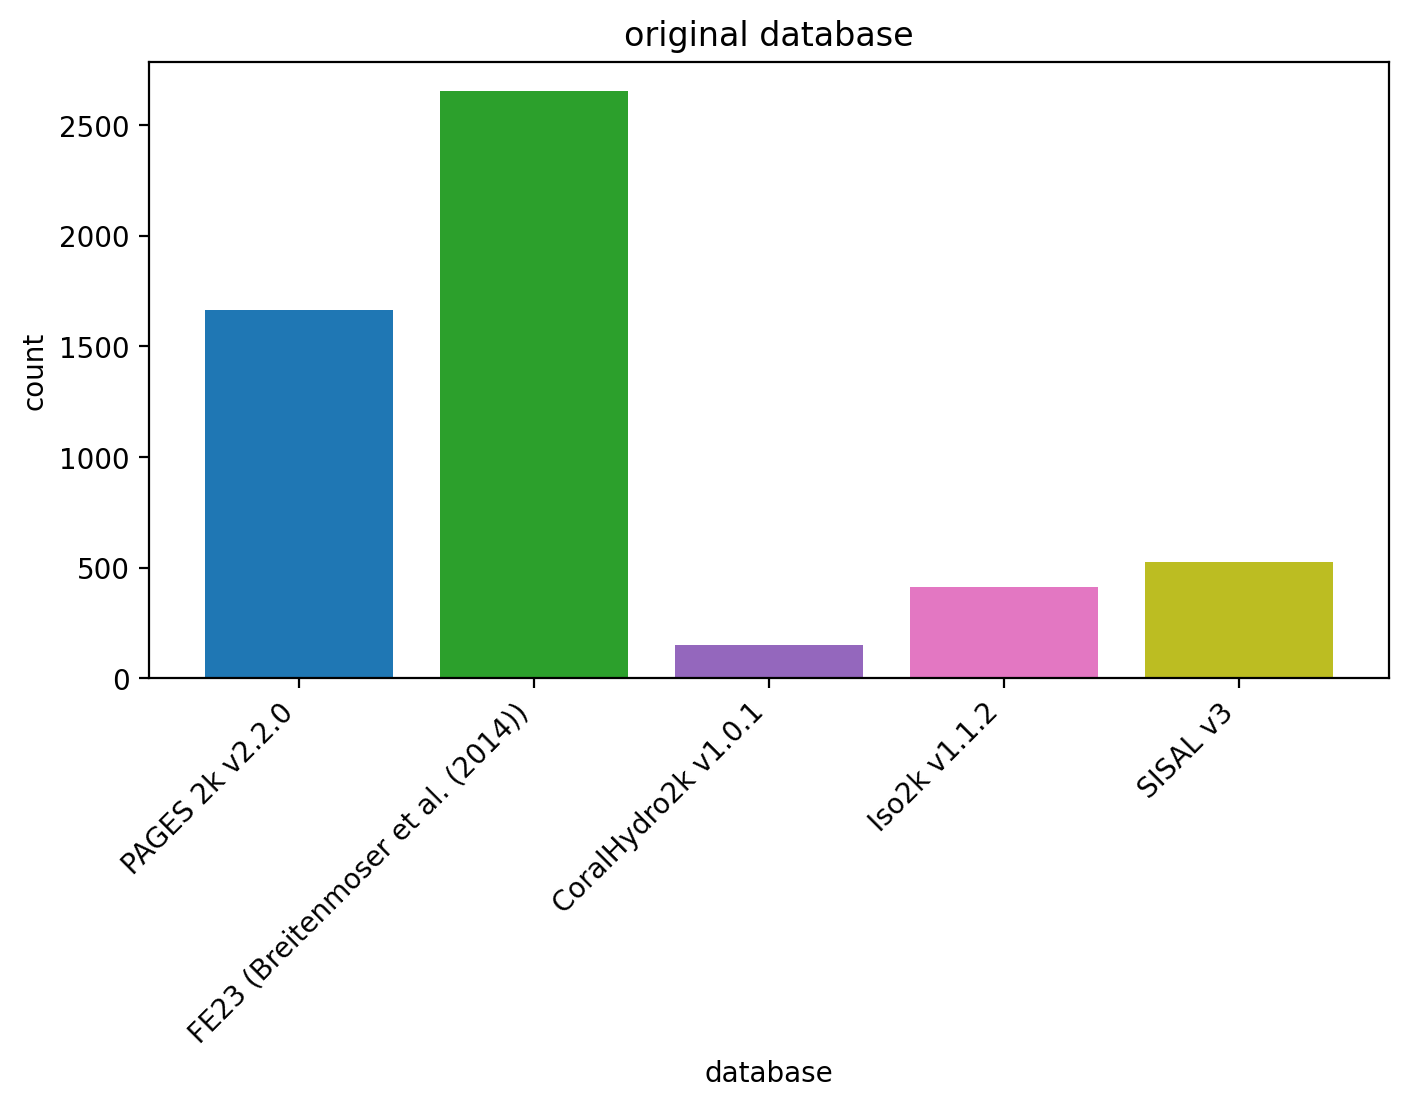

saved figure in /figs/all_merged_LL_25-11-11_dupfree//SF_removed_recs_barchart_databases.pdf


In [68]:
# plot a bar chart of the number of proxy types included in the dataset
fig = plt.figure(figsize=(8,4), dpi=200)
ax  = plt.gca()
plt.bar(range(len(ticks)), counts, color=colours)
plt.xlabel('database')
plt.ylabel('count')
ax.set_xticks(range(len(ticks)), ticks, rotation=45, ha='right')
#ax.set_xticklabels(proxy_types, rotation=45, ha='right')
plt.title('original database')
plt.show()
fig.tight_layout()
utf.figsave(fig, 'SF_removed_recs_barchart_databases', add='%s/'%df_dupfree.name)

In [69]:
#%% print some info about the data
proxy_types   = df_dupfree_rmv['paleoData_proxy'].unique()
archive_types = df_dupfree_rmv['archiveType'].unique()
print(proxy_types)
print(archive_types)
col = uplt.get_colours(range(0,len(archive_types)), 'Accent', -1, len(archive_types))
counts      = []
ticks       = []
colours     = []
for ii, at in enumerate(archive_types):
    proxy_types   = df_dupfree_rmv['paleoData_proxy'][df_dupfree_rmv['archiveType']==at].unique()
    for pt in proxy_types:
        cc = df_dupfree_rmv['paleoData_proxy'][(df_dupfree_rmv['paleoData_proxy']==pt)&(df_dupfree_rmv['archiveType']==at)].count()
        # print('%25s'%pt+': '+str(cc))
        counts  += [cc]
        ticks   += [at+': '+pt]
        colours += [col[ii]]
        

['ring width' 'residualChronology' 'ARSTAN' 'RBAR' 'core'
 'maximum latewood density' 'reflectance' 'EPS' 'd18O' 'd13C' 'Sr/Ca'
 'Mg/Ca' 'temperature' 'historical' 'varve thickness' 'ice melt'
 'alkenone' 'chironomid' 'Uk37' 'borehole' 'pollen' 'depth' 'dinocyst'
 'count' 'concentration' 'chrysophyte assemblage' 'dD'
 'calcification rate' 'depthTop' 'depthBottom' 'foraminifera' 'BSi' 'dust'
 'chloride' 'sulfate' 'nitrate' 'thickness' 'duration' 'TEX86'
 'effectivePrecipitation' 'diatom' 'multiproxy' 'humidificationIndex'
 'accumulation rate' 'sodium' 'growth rate']
['Wood' 'Coral' 'LakeSediment' 'MarineSediment' 'Documents' 'GlacierIce'
 'Borehole' 'Sclerosponge' 'Speleothem' 'Other' 'GroundIce' 'MolluskShell'
 'speleothem']


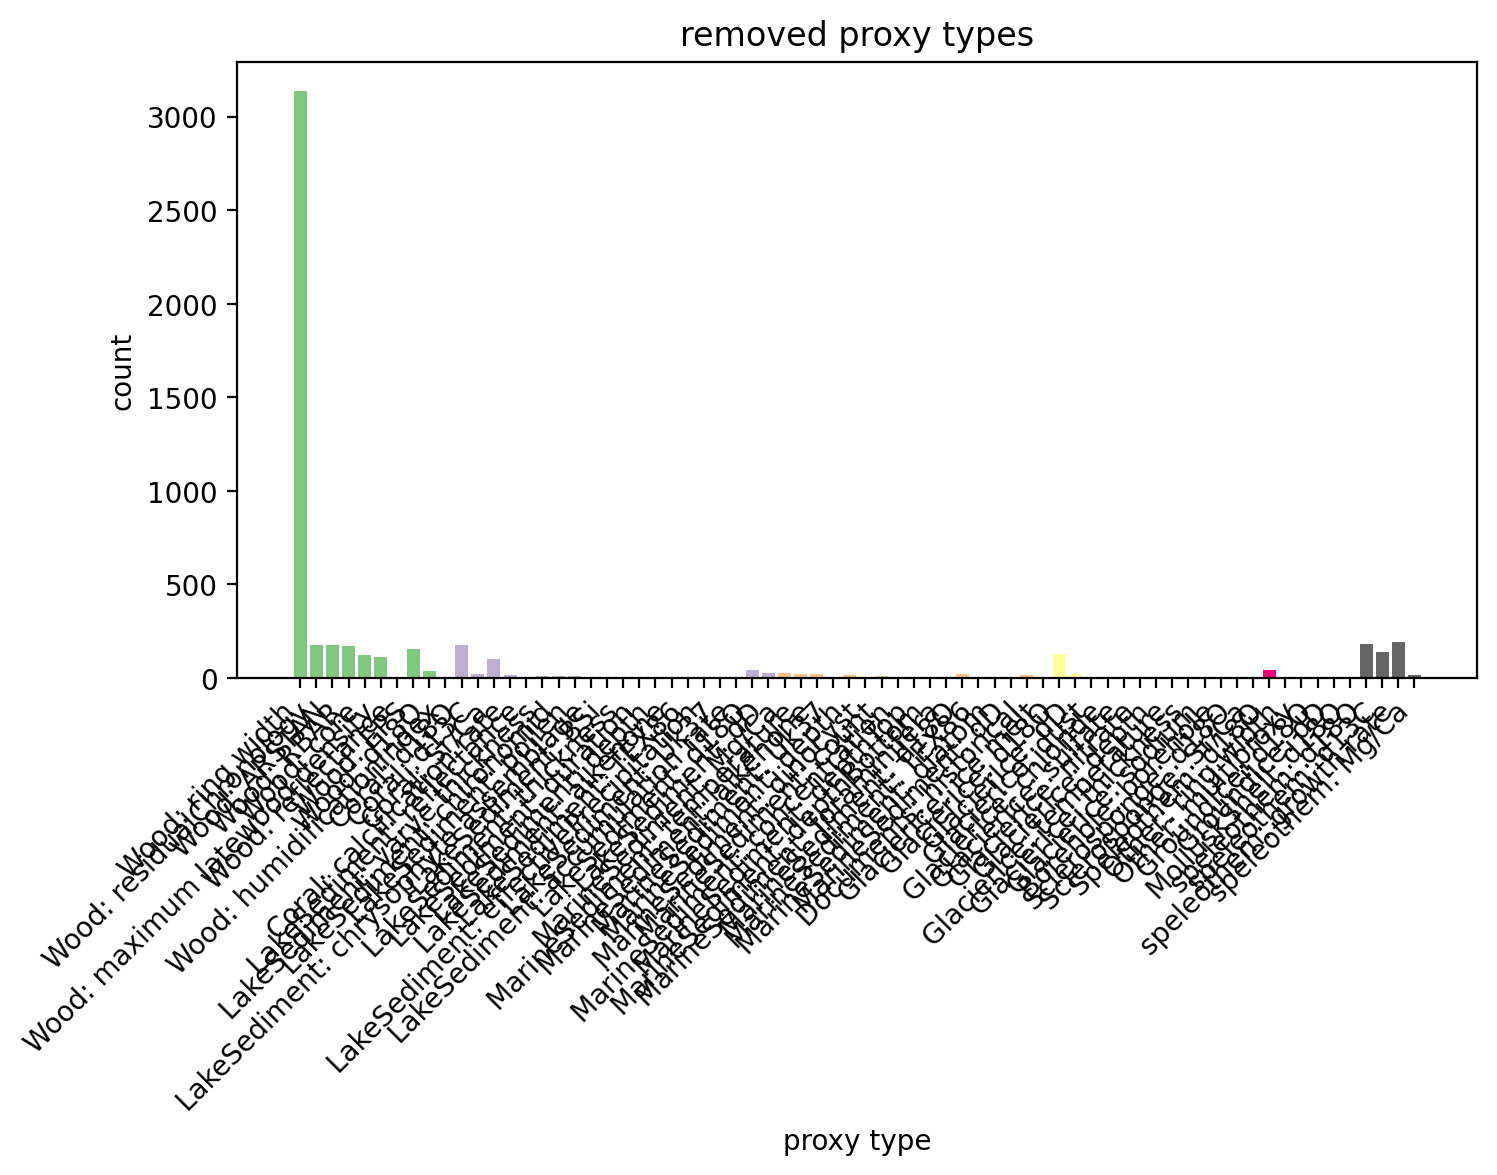

saved figure in /figs/all_merged_LL_25-11-11_dupfree//SF_removed_recs_barchart_proxytypes.pdf


In [70]:
# plot a bar chart of the number of proxy types included in the dataset
fig = plt.figure(figsize=(8, 4), dpi=200)
ax  = plt.gca()
plt.bar(range(len(ticks)), counts, color=colours)

plt.xlabel('proxy type')
plt.ylabel('count')
ax.set_xticks(range(len(ticks)), ticks, rotation=45, ha='right')
#ax.set_xticklabels(proxy_types, rotation=45, ha='right')
plt.title('removed proxy types')
plt.show()
fig.tight_layout()
utf.figsave(fig, 'SF_removed_recs_barchart_proxytypes', add='%s/'%df_dupfree.name)


/tmp/ipykernel_703226/3804216409.py:36: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  grid.tight_layout(fig)


saved figure in /figs/all_merged_LL_25-11-11_dupfree//SF_removed_spatial.pdf


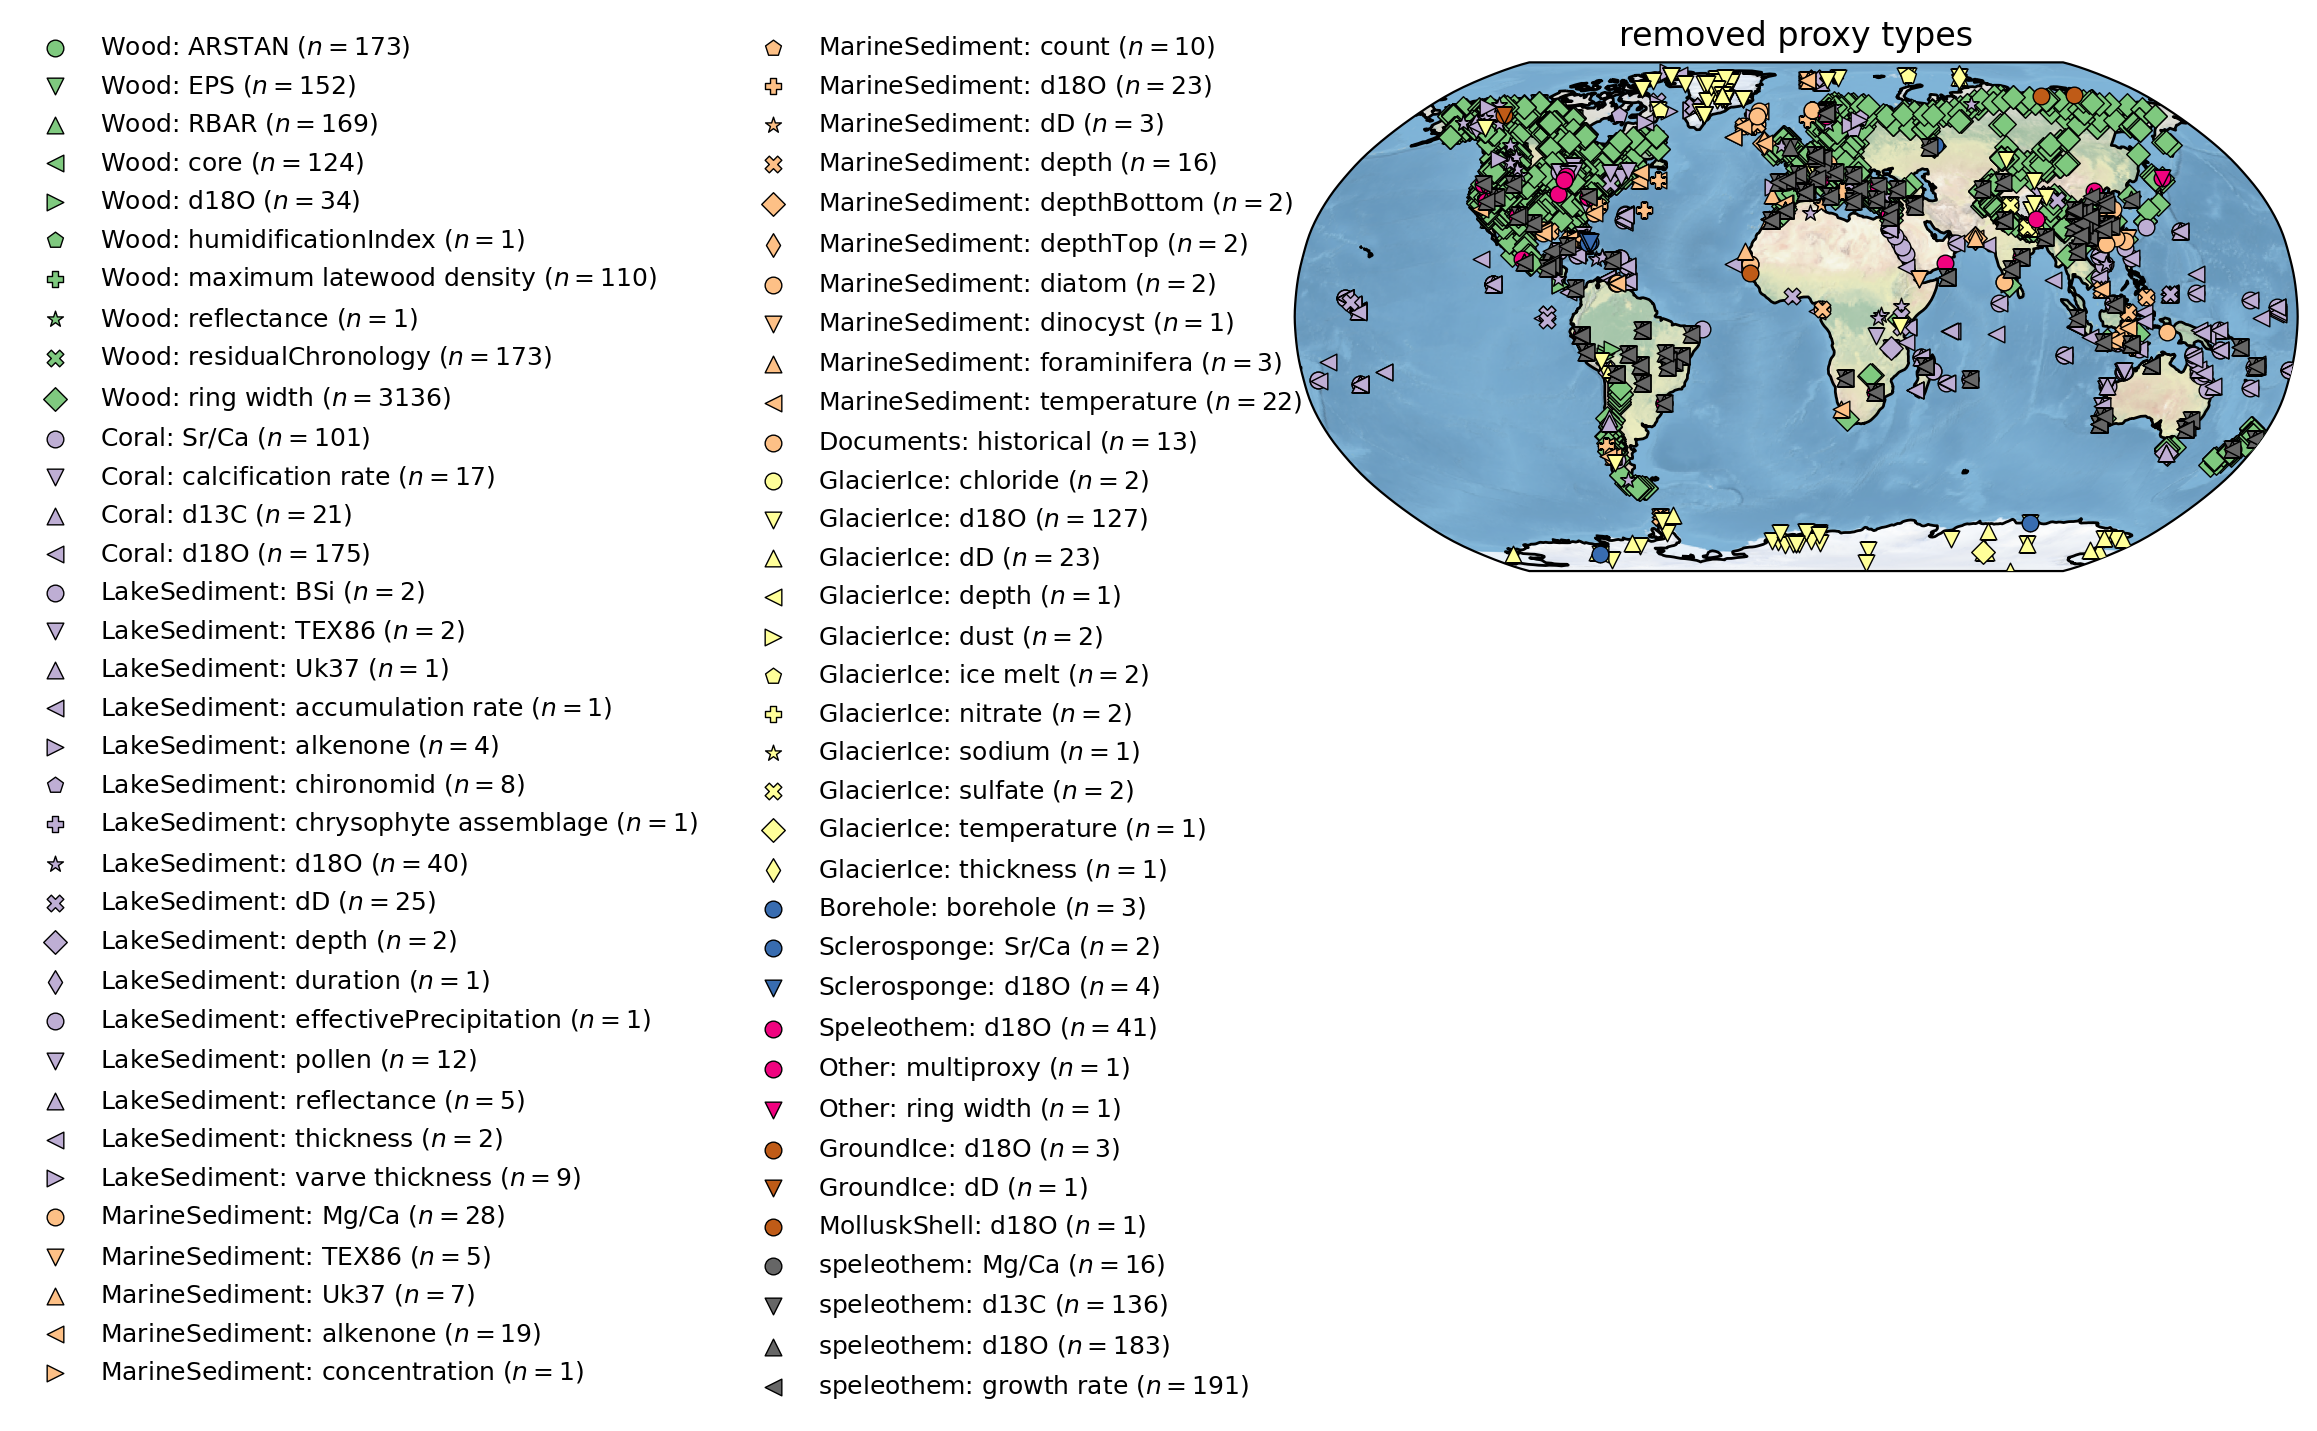

In [71]:
#%% plot the spatial distribution of the removeed records
proxy_lats = df_dupfree_rmv['geo_meanLat'].values
proxy_lons = df_dupfree_rmv['geo_meanLon'].values

# plots the map
fig = plt.figure(figsize=(10, 5), dpi=200)
grid = GS(1, 3)

ax = plt.subplot(grid[:, -2:], projection=ccrs.Robinson()) # create axis with Robinson projection of globe
ax.stock_img()
ax.add_feature(cfeature.LAND) # adds land features
ax.coastlines() # adds coastline features


mt = 'ov^<>pP*XDd'*10 # generates string of marker types
archive_marker = {aa: mm for aa, mm in zip(archive_types, mt)} # attributes marker type to each archive type
archive_colour = {aa: cc for aa, cc in zip(archive_types, col)}

# loop through the data to generate a scatter plot of each data record:
# 1st loop: go through archive types individually (determines marker type)
# 2nd loop: through paleo proxy types attributed to the specific archive, which is colour coded
for jj, at in enumerate(archive_types):
    arch_mask = df_dupfree_rmv['archiveType']==at
    arch_proxy_types = np.unique(df_dupfree_rmv['paleoData_proxy'][arch_mask])
    for ii, pt in enumerate(arch_proxy_types):
        pt_mask = df_dupfree_rmv['paleoData_proxy']==pt
        at_mask = df_dupfree_rmv['archiveType']==at
        plt.scatter(proxy_lons[pt_mask&at_mask], proxy_lats[pt_mask&at_mask], 
                    transform=ccrs.PlateCarree(), zorder=999,
                    marker=mt[ii], color=archive_colour[at], 
                    label=at+': '+pt+' ($n=%d$)'% df_dupfree_rmv['paleoData_proxy'][(df_dupfree_rmv['paleoData_proxy']==pt)&(df_dupfree_rmv['archiveType']==at)].count(), 
                    lw=.5, ec='k')

plt.title('removed proxy types')
plt.legend(bbox_to_anchor=(0.03,1.1), ncol=2, fontsize=9, framealpha=0)
grid.tight_layout(fig)
utf.figsave(fig, 'SF_removed_spatial', add='%s/'%df_dupfree.name)
